In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import AgglomerativeClustering

In [2]:
import numpy as np
import pandas as pd
import scanpy as sc
import scipy.io
import matplotlib.pyplot as plt
import os
import anndata
import harmonypy as hm
import seaborn as sns
import scrublet as scr
import bbknn as bk
%matplotlib inline

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
sc.settings.set_figure_params(dpi=250,fontsize=10)

In [4]:
adata = sc.read_h5ad("/rds/general/user/snb20/home/2_Organotypic_EC_Heterogeneity/Sanger_Datasets/Resolve/Test/Test2_nolog/bin50_A2-2.h5ad")

In [5]:
adata

AnnData object with n_obs × n_vars = 30137 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [6]:
adata.obs['arterial_smc'] = (adata.X[:,adata.var_names=='MYH11'] > 1) & (adata.X[:,adata.var_names=='TTN'] == 0)

In [7]:
adata_aec = adata[adata.obs['arterial_smc'] == True]

In [8]:
adata_aec

View of AnnData object with n_obs × n_vars = 337 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_smc'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [9]:
data = adata_aec.obs[['X_coor','Y_coor']]
linkage_data = linkage(data, method='average', metric='euclidean')

In [10]:
temp = dendrogram(linkage_data,no_plot=True)

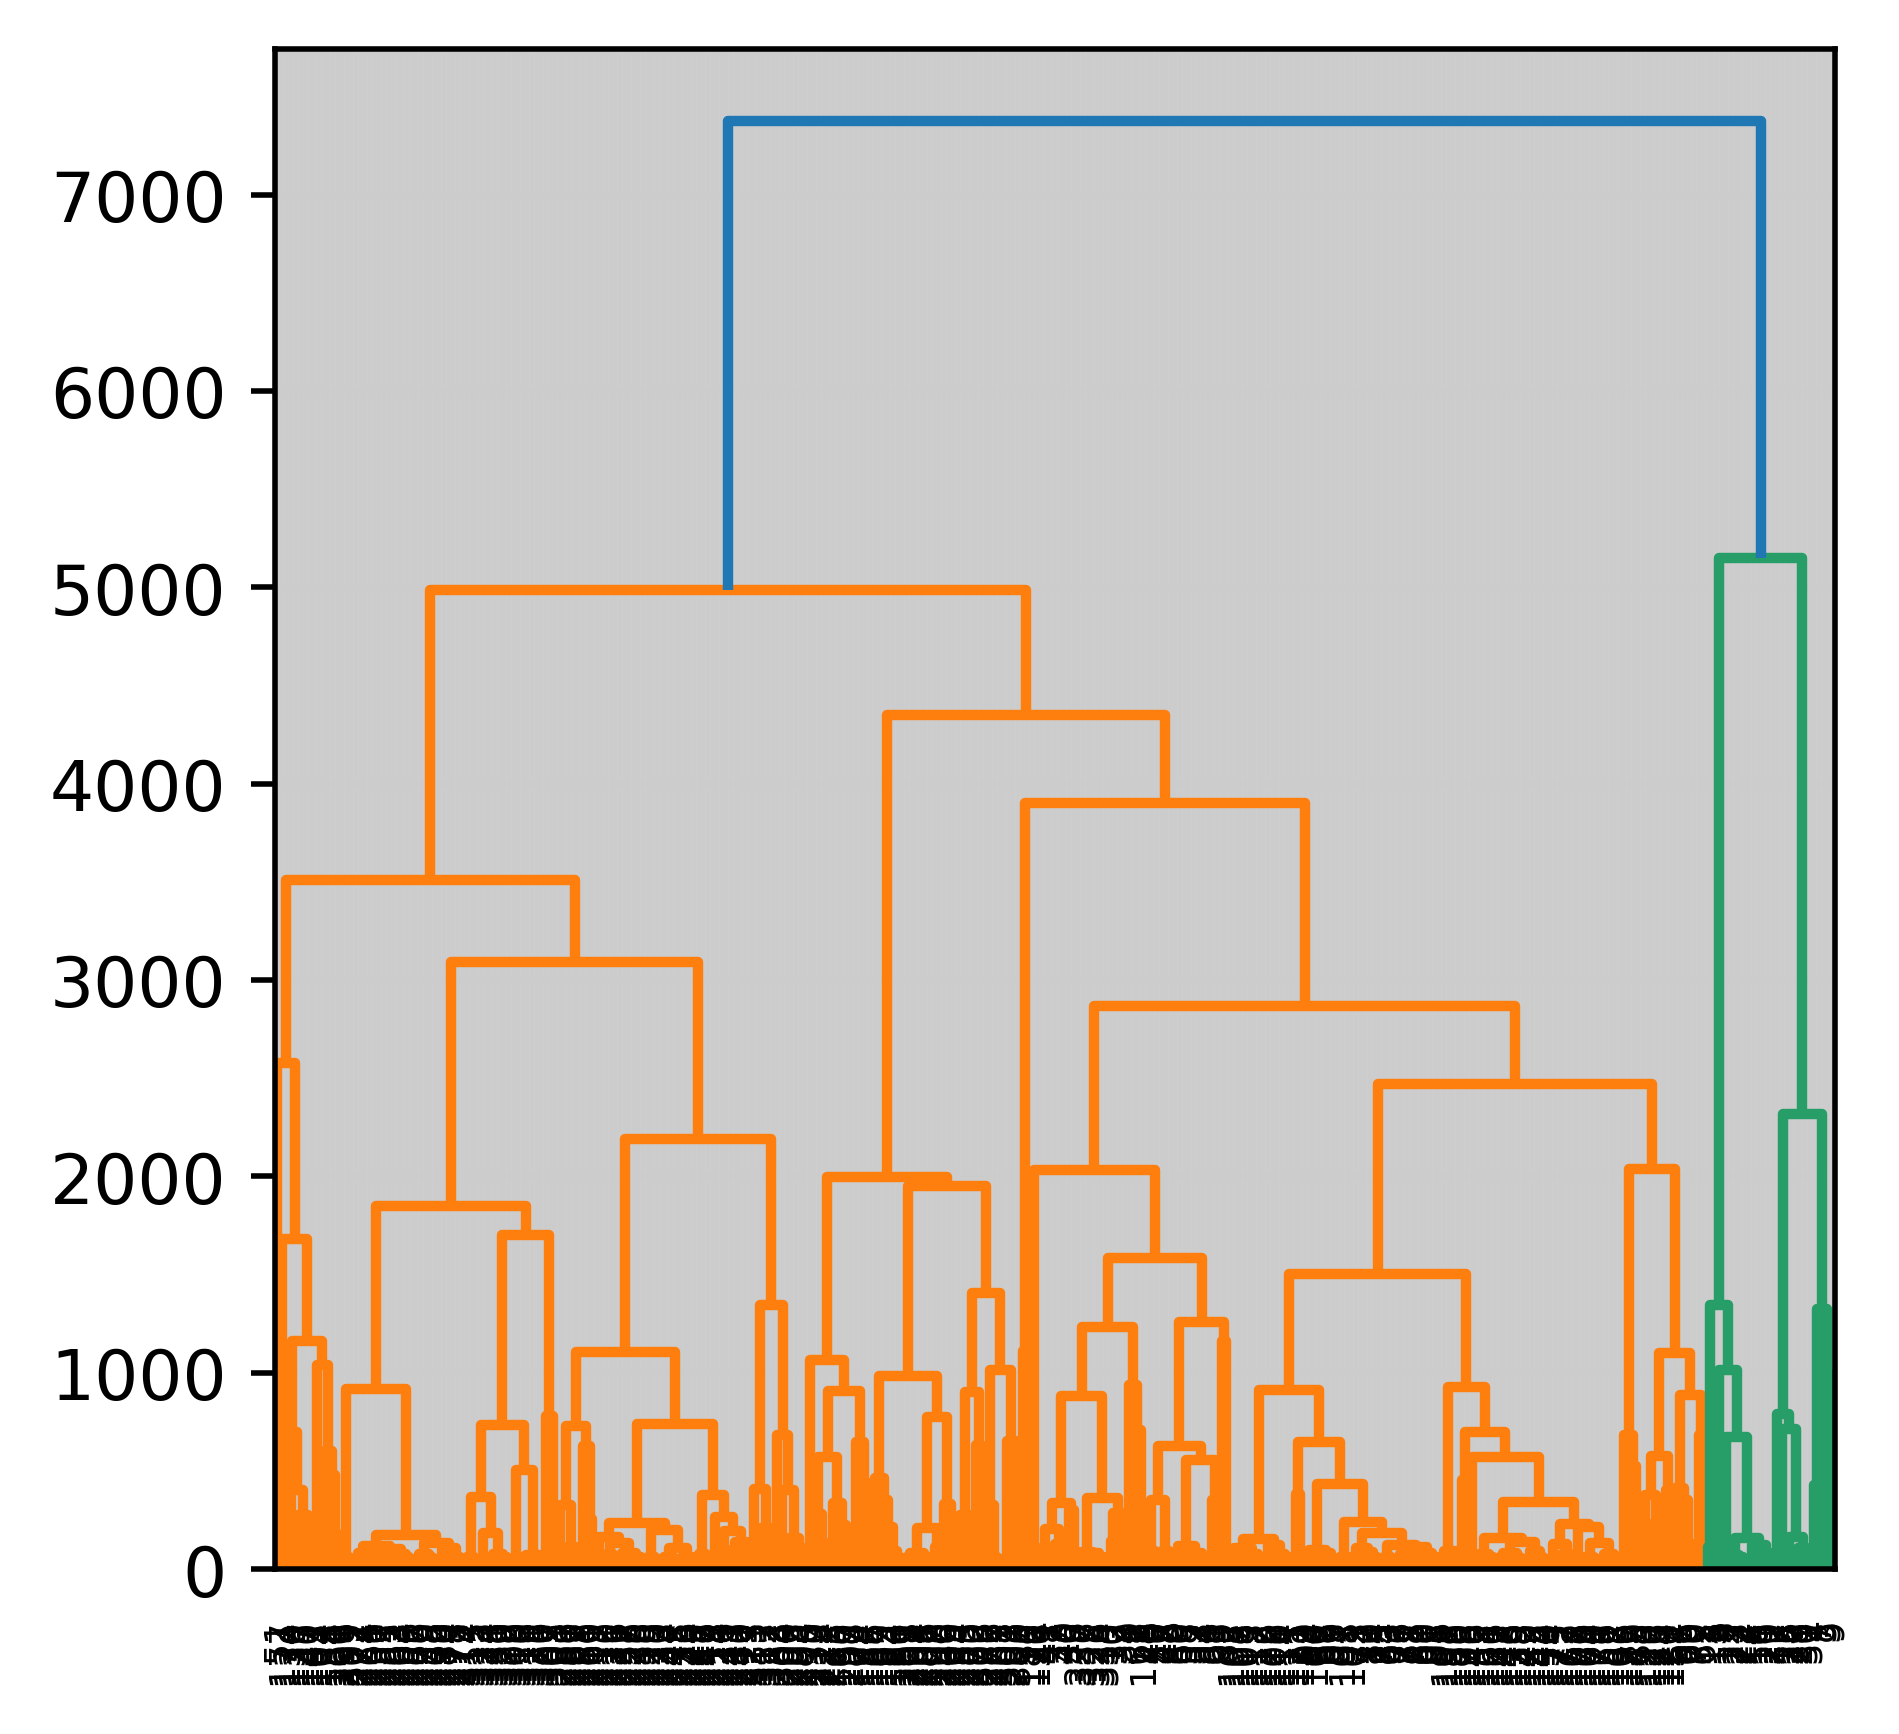

In [11]:
dendrogram(linkage_data)
plt.show()

In [12]:
adata_aec

View of AnnData object with n_obs × n_vars = 337 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_smc'
    var: 'Genes'
    uns: 'spatial'
    obsm: 'spatial'

In [13]:
# adjust n_clusters to relevant number of vessels
hierarchical_cluster = AgglomerativeClustering(n_clusters=150, affinity='euclidean', linkage='single')

In [14]:
labels = hierarchical_cluster.fit_predict(data) 
print(labels)

[ 91 123  23  77 125 103  78 127 109  83 116 117 107 112   9  81   9  87
   9   9   9   9   9   9   9   9  16  16  15  15   7   7 114  75  94 111
 110 128   3  99   3   3   3  96   3   1   1   1   4   4   4 129 131  72
  72  72  72  72  72  72  72 139  89 121 141  88  93  82  51  62  62   2
   2   2   2   2   2   2   2  98   2   2   2   2   2 140  31  31  31   2
   2   2   2  31  31   2   2   2   2  31  31   2   2 130 149   6   6   6
   6   6   6   6   6   6   6   6   6   6  51  33 137  95   6  52  52 119
 100 113  27  27 115 145 118 105  85  20  33  20  68  68  10  10  68  68
  68  68 135  68  68  68  68 108  68  68 124  68  68  35  35  35  53  68
  68  35  35  35  35  35  35  40  35  35  35  35  35  35  47 143 147  54
  29  29 106  29 142  55 144  86  79   0   0   0  74  63 148 136 102   5
 120   5  38  14  14   5  14  80  14  14  14  92  32  50  50  97  71  45
 126  67  90  61  61  32  44 138 146  61  32  32  32  32  48 134  73  32
  32  32  32  32  32  32  43  36  32  32  32  32 13

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/sklearn/cluster/_agglomerative.py:983: FutureWarning: Attribute `affinity` was deprecated in version 1.2 and will be removed in 1.4. Use `metric` instead
  warnings.warn(


In [15]:
adata_aec.obs['SMC_clusters'] = labels
adata_aec.obs['SMC_clusters'] = adata_aec.obs['SMC_clusters'].astype('category')

/var/tmp/pbs.7737892.pbs/ipykernel_64700/1883412233.py:1: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  adata_aec.obs['SMC_clusters'] = labels
/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/contextlib.py:142: FutureWarning: X.dtype being converted to np.float32 from int64. In the next version of anndata (0.9) conversion will not be automatic. Pass dtype explicitly to avoid this warning. Pass `AnnData(X, dtype=X.dtype, ...)` to get the future behavour.
  next(self.gen)


In [16]:
adata_aec.obs['SMC_clusters'].value_counts()

60     24
2      23
32     17
68     16
35     15
       ..
73      1
71      1
70      1
69      1
149     1
Name: SMC_clusters, Length: 150, dtype: int64

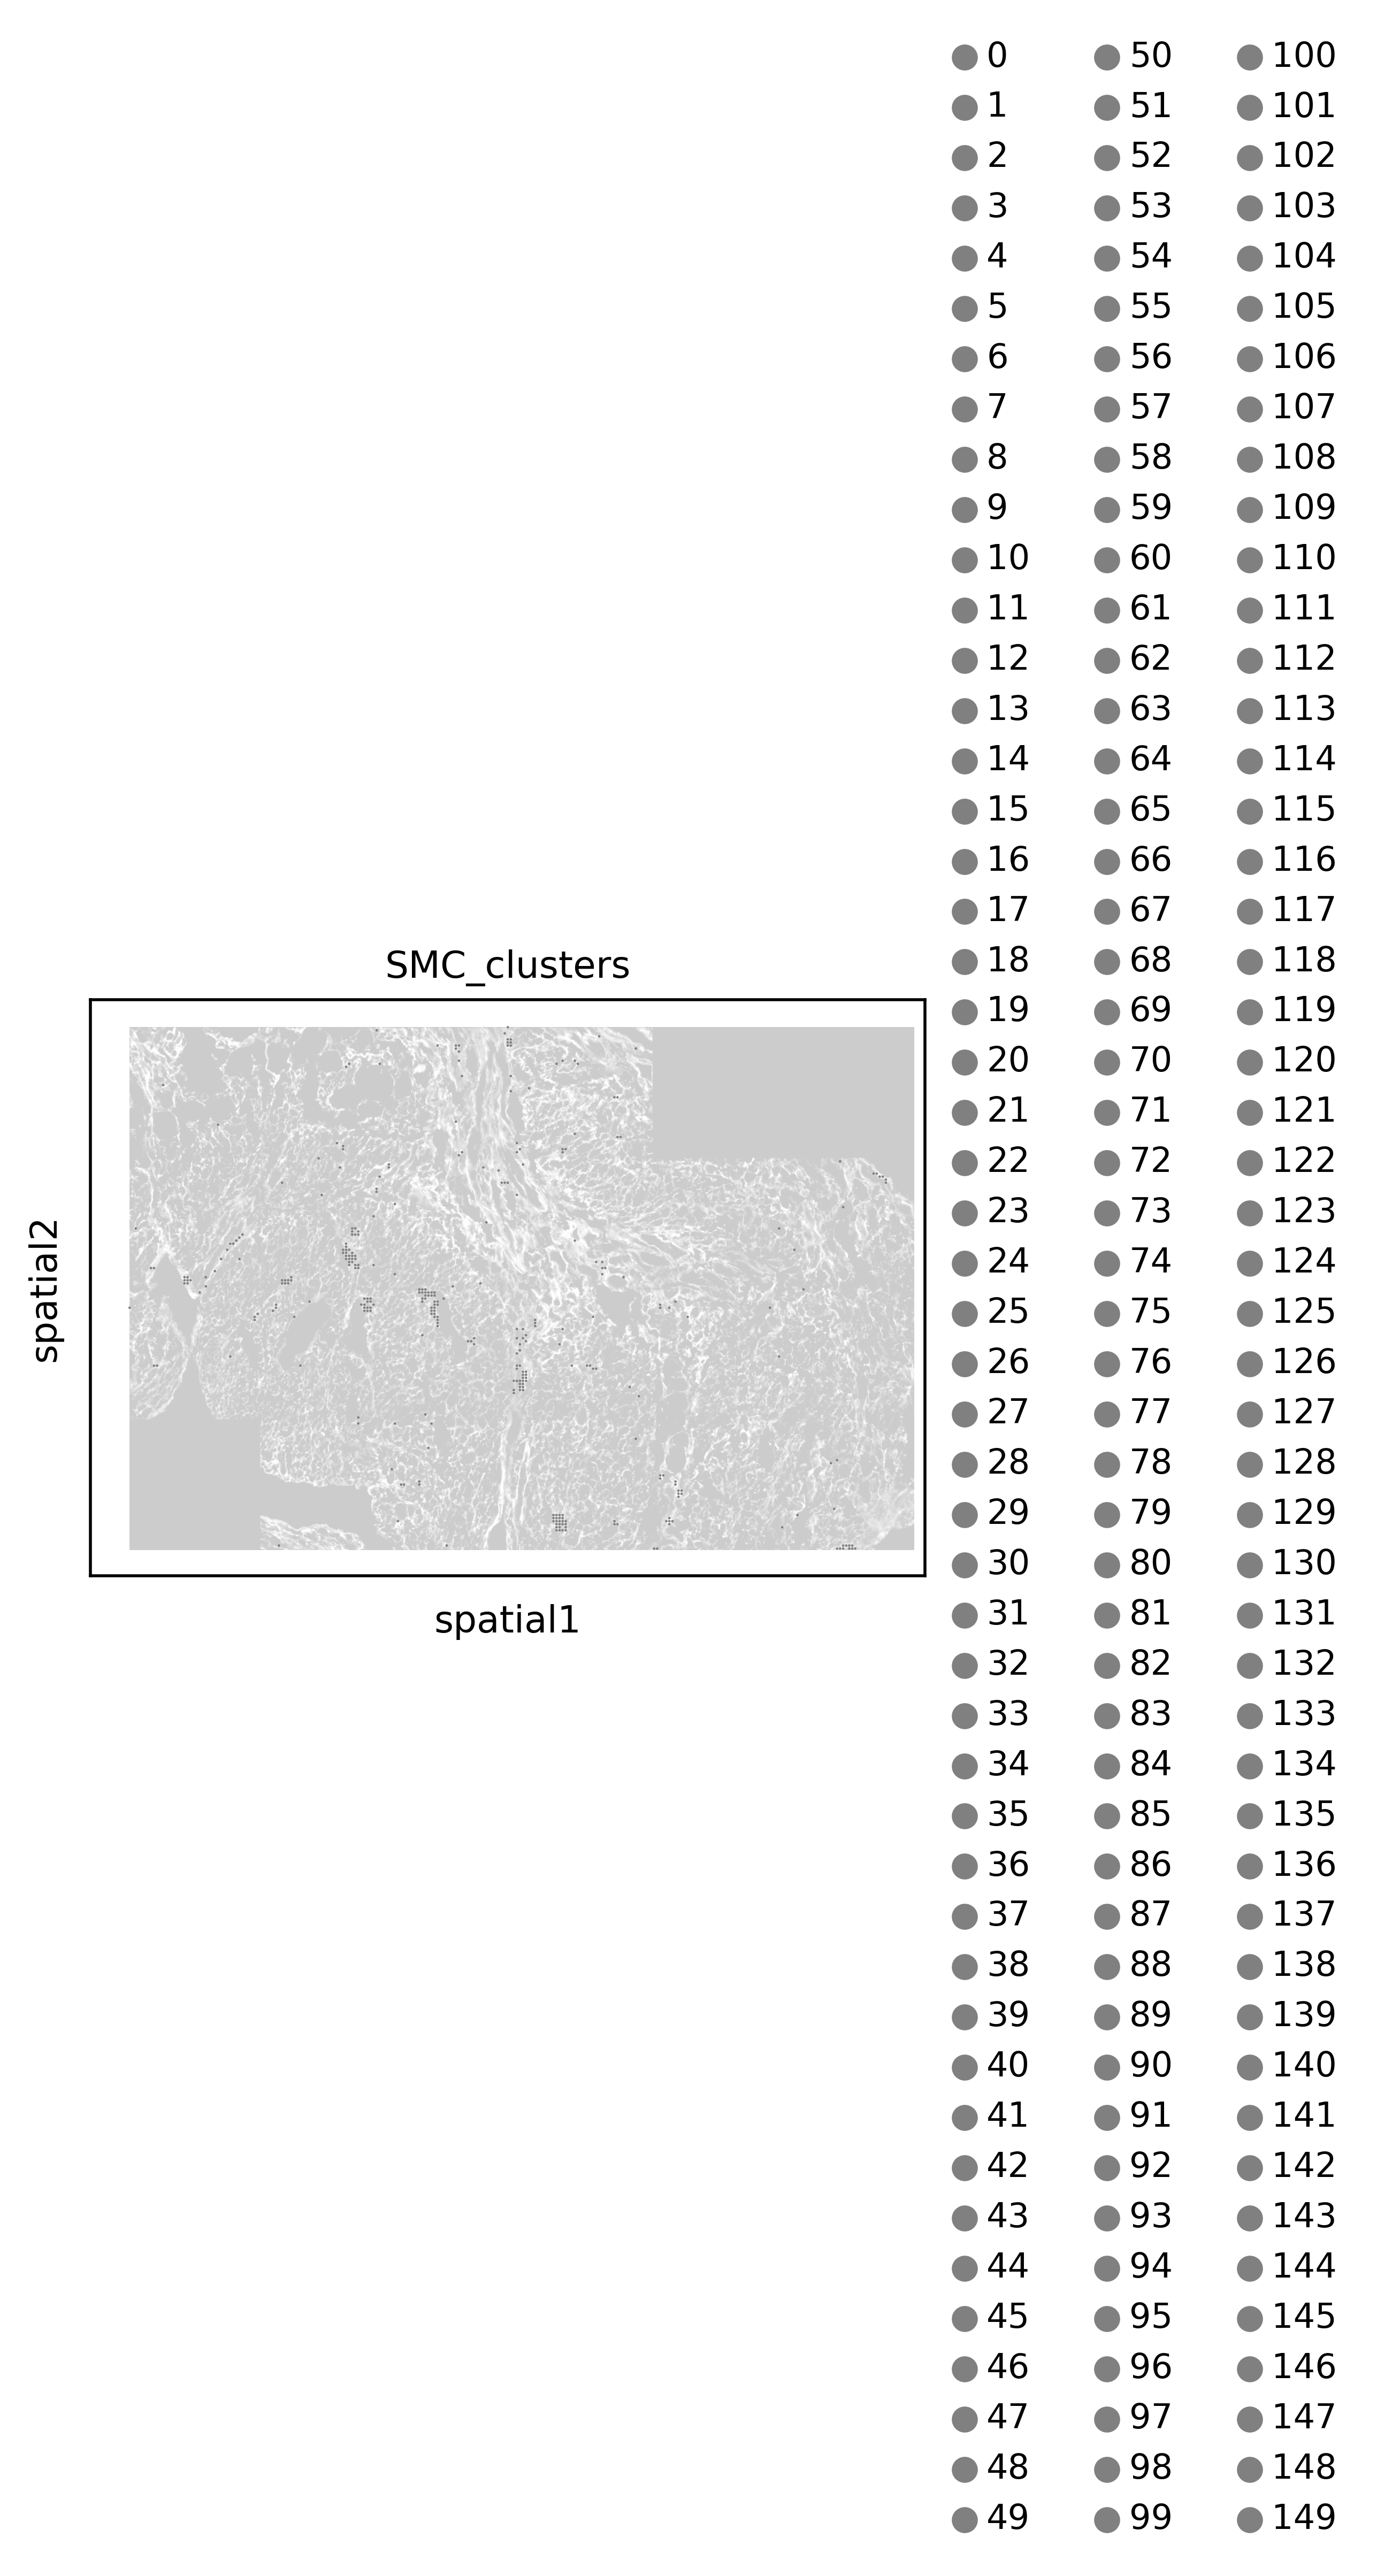

In [17]:
sc.pl.spatial(adata_aec, color="SMC_clusters",img_key='WGA',size=8, alpha_img = 0.2)

In [18]:
# subset for clusters > 5 bins
adata_aec.obs['SMC_clusters'].value_counts()[adata_aec.obs['SMC_clusters'].value_counts() > 5].index.tolist()

[60, 2, 32, 68, 35, 6, 9, 72, 31, 23, 14]

In [19]:
adata_aec_subset = adata_aec[adata_aec.obs.SMC_clusters.isin(adata_aec.obs['SMC_clusters'].value_counts()[adata_aec.obs['SMC_clusters'].value_counts() > 5].index.tolist())]

In [20]:
adata_aec_subset.obs.SMC_clusters = adata_aec_subset.obs.SMC_clusters.astype(str).astype('category')

/rds/general/user/snb20/home/anaconda3/envs/scanpy1.8.2/lib/python3.10/site-packages/pandas/core/generic.py:5931: ImplicitModificationWarning: Trying to modify attribute `.obs` of view, initializing view as actual.
  self[name] = value


In [21]:
adata_aec_subset

AnnData object with n_obs × n_vars = 147 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_smc', 'SMC_clusters'
    var: 'Genes'
    uns: 'spatial', 'SMC_clusters_colors'
    obsm: 'spatial'

In [22]:
del adata_aec_subset.uns['SMC_clusters_colors']

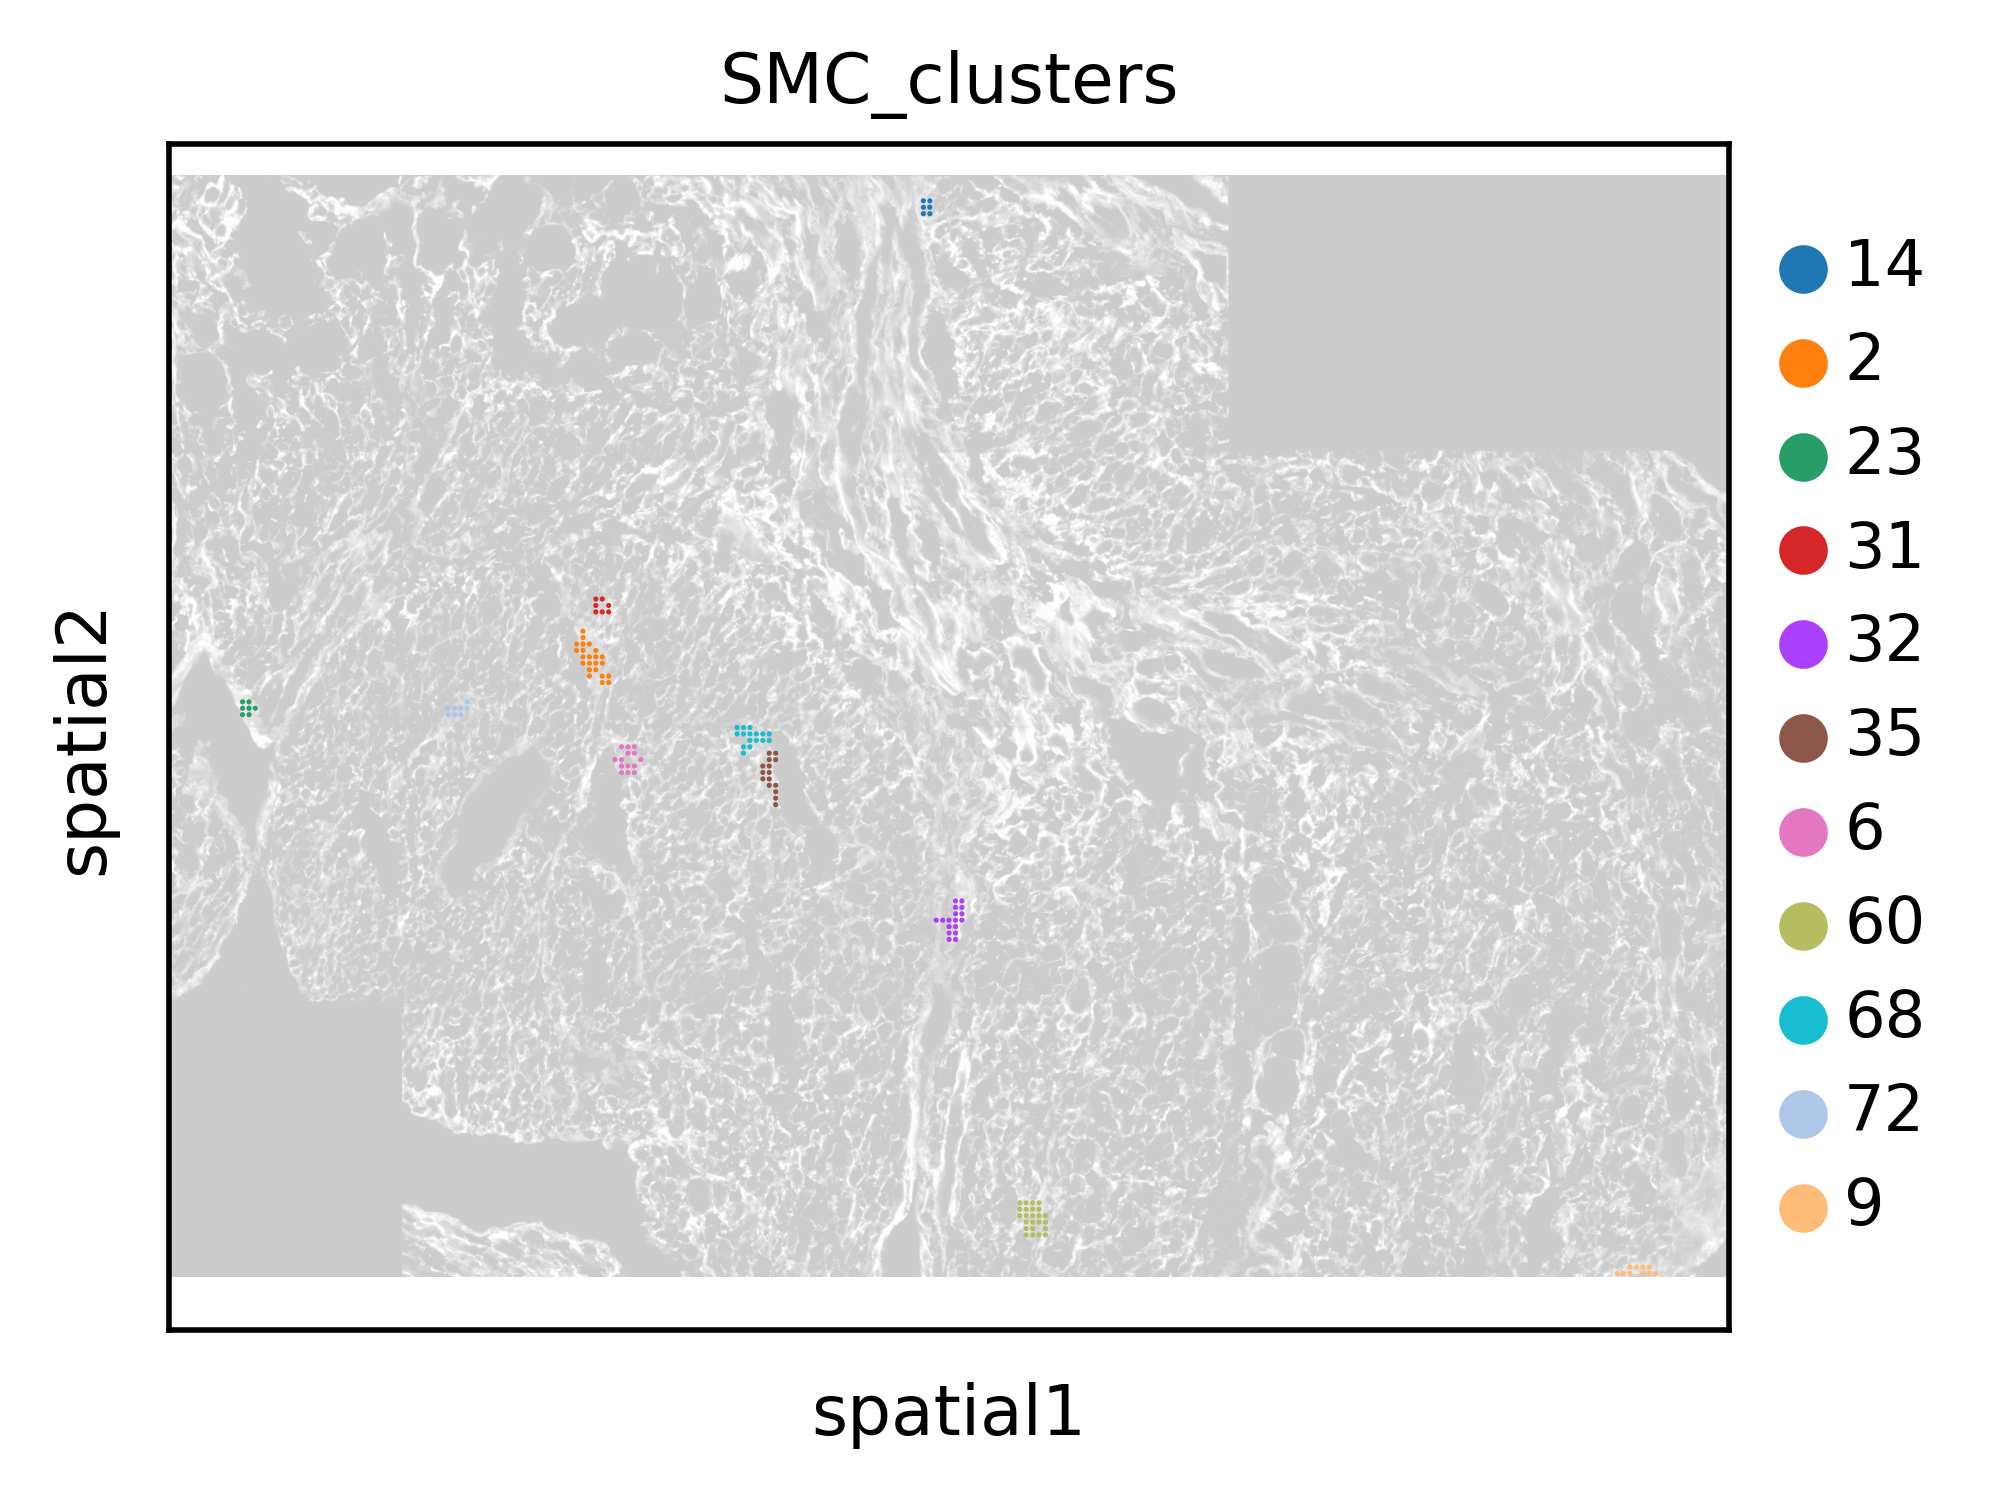

In [23]:
sc.pl.spatial(adata_aec_subset,
              color="SMC_clusters",img_key='WGA',size=8, alpha_img = 0.2)

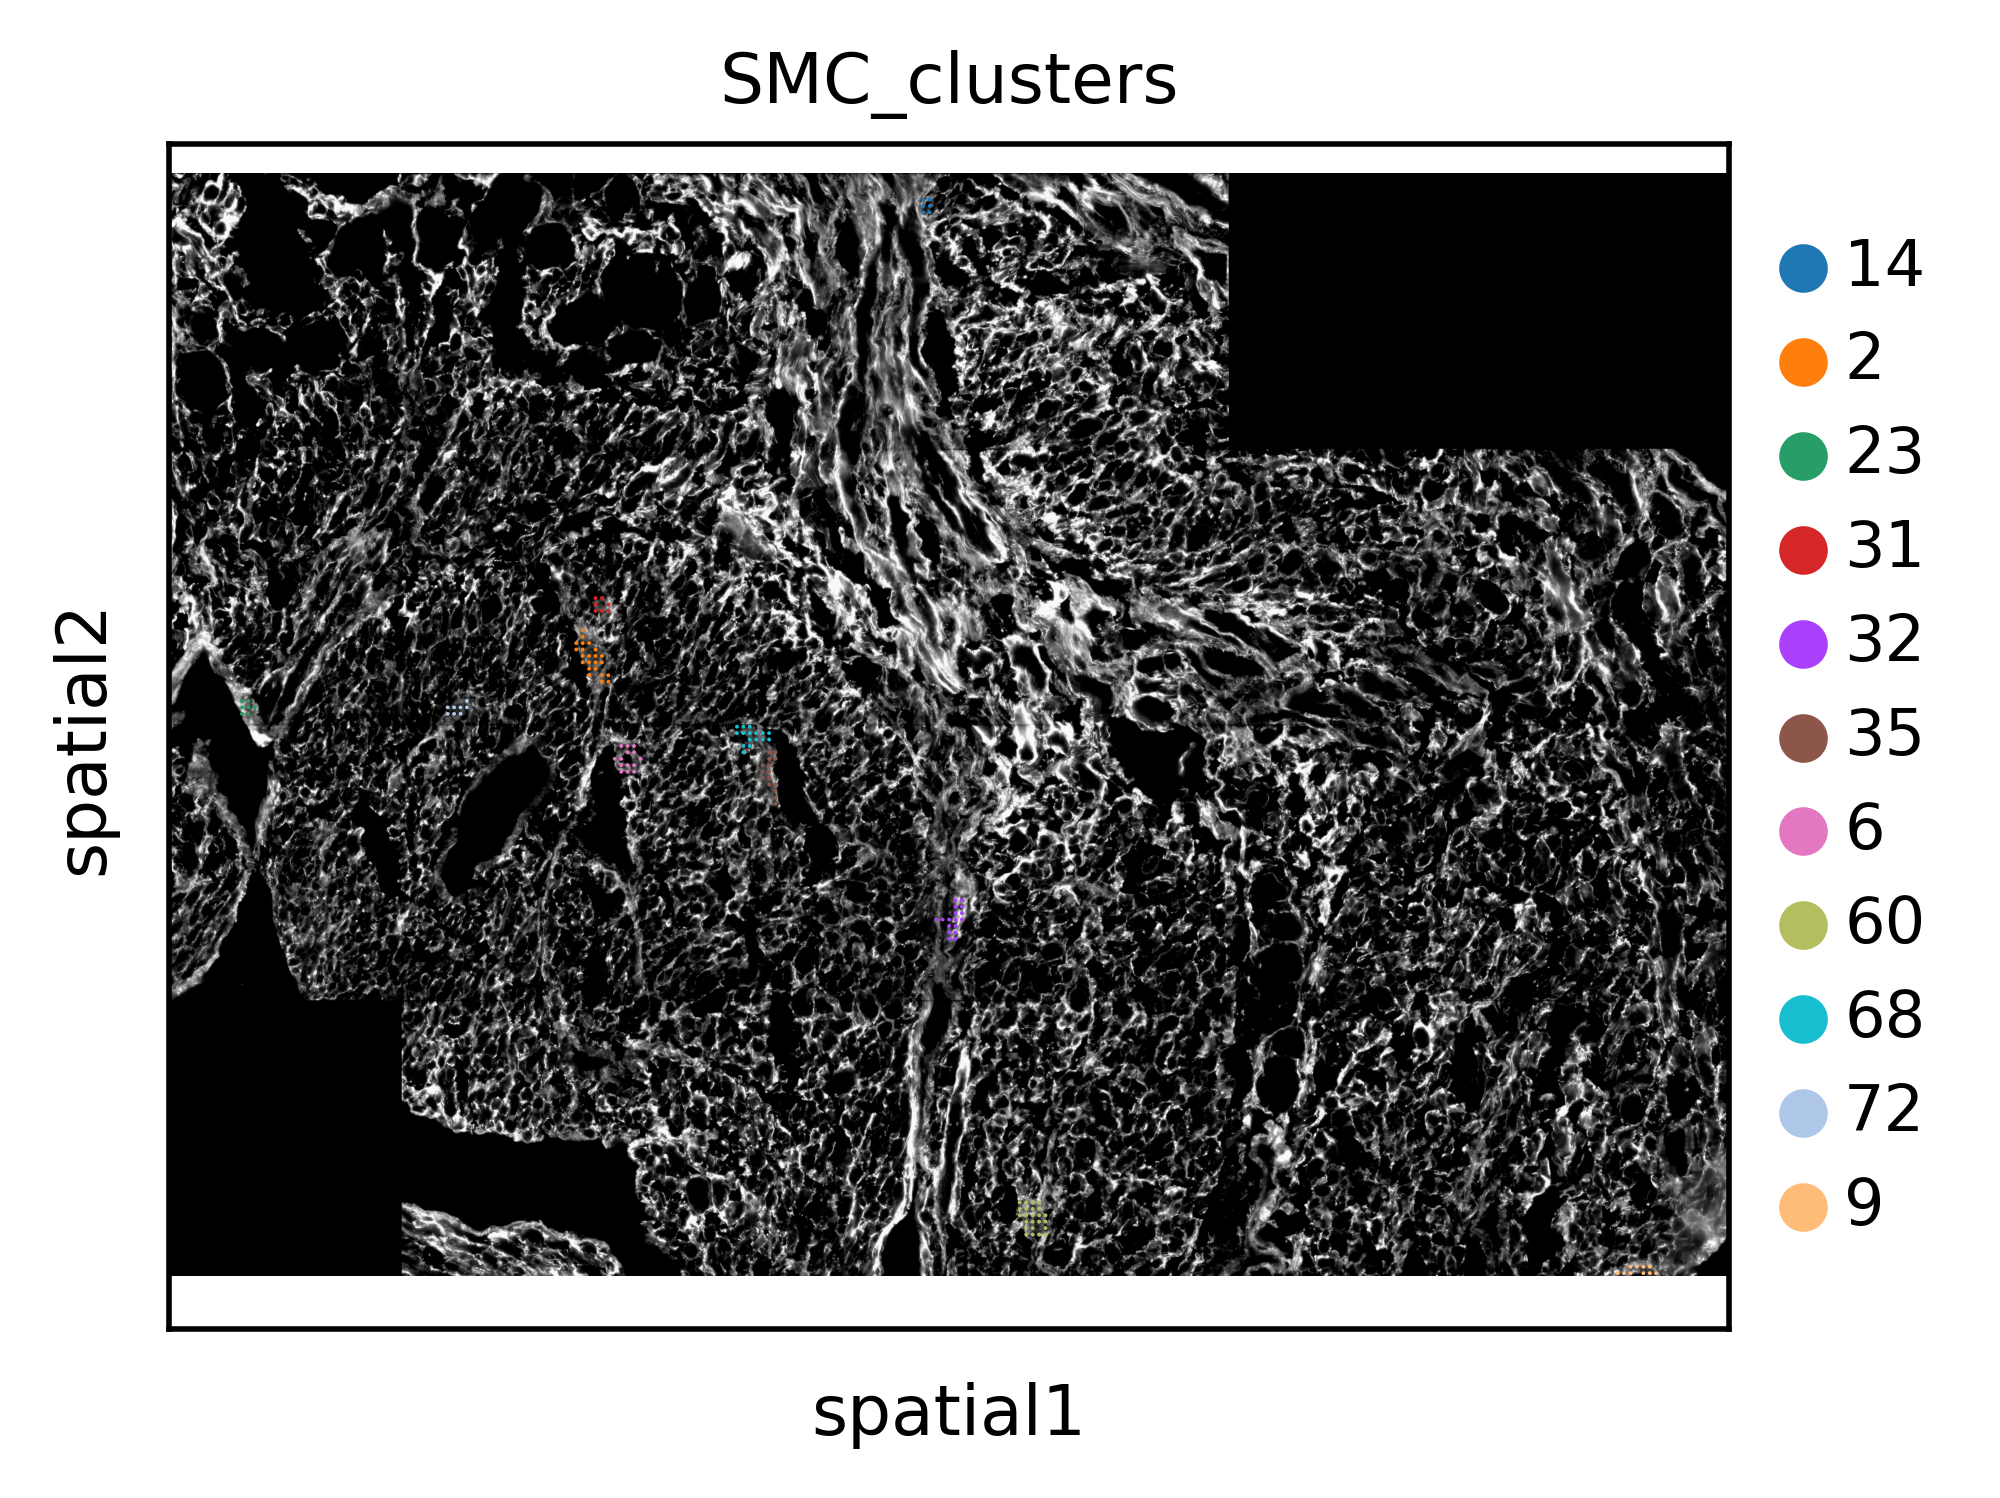

In [24]:
sc.pl.spatial(adata_aec_subset,
              color="SMC_clusters",img_key='WGA',size=6)

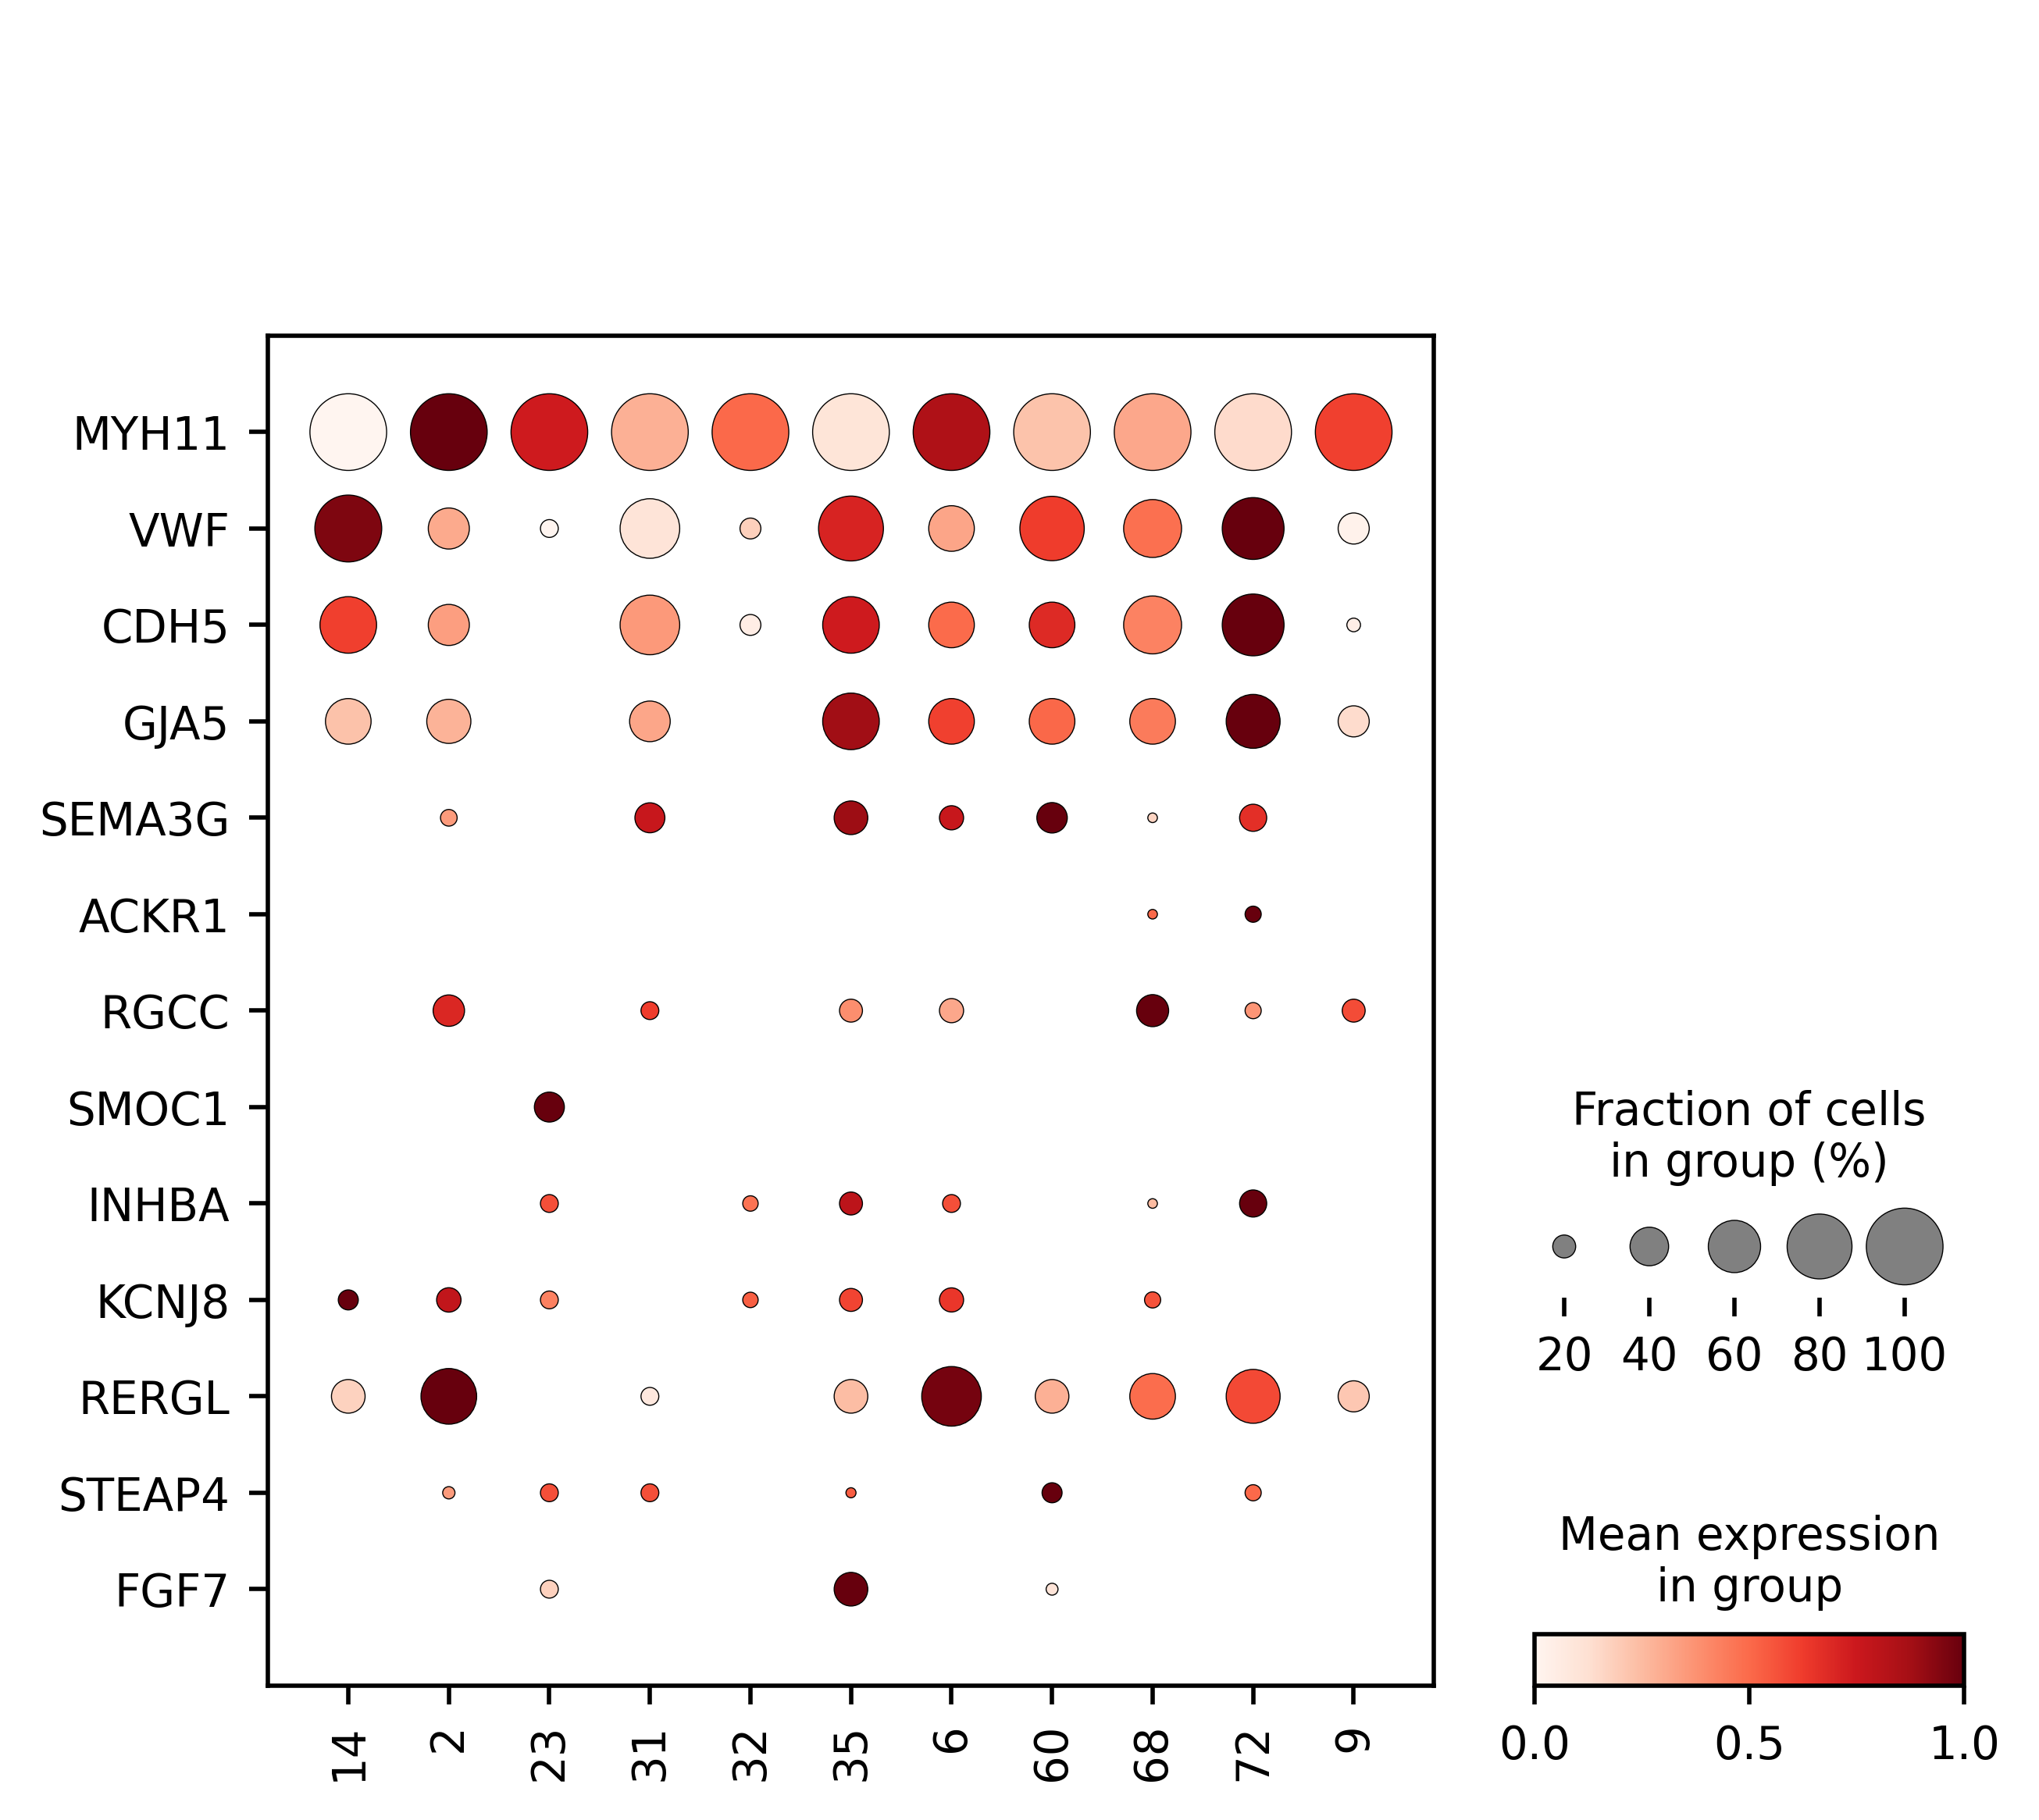

In [25]:
markers = ["MYH11","VWF","CDH5","GJA5","SEMA3G","ACKR1","RGCC","SMOC1","INHBA","KCNJ8","RERGL","STEAP4","FGF7"]
sc.pl.dotplot(adata_aec_subset, markers, "SMC_clusters", cmap = 'Reds', swap_axes = True, standard_scale = 'var')

In [26]:
# add gene percentage expressed to dataframe

In [27]:
adata_aec_subset.obs['RERGL_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='RERGL'] > 0)

In [28]:
adata_aec_subset.obs['STEAP4_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='STEAP4'] > 0)

In [29]:
adata_aec_subset.obs['FGF7_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='FGF7'] > 0)

In [30]:
adata_aec_subset.obs['KCNJ8_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='KCNJ8'] > 0)

In [31]:
adata_aec_subset.obs['AGT_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='AGT'] > 0)

In [32]:
adata_aec_subset.obs['STEAP4_FGF7_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='STEAP4'] > 1) & (adata_aec_subset.X[:,adata_aec_subset.var_names=='FGF7'] > 0)

In [33]:
adata_aec_subset.obs['STEAP4_KCNJ8_percent'] = (adata_aec_subset.X[:,adata_aec_subset.var_names=='STEAP4'] > 1) & (adata_aec_subset.X[:,adata_aec_subset.var_names=='KCNJ8'] > 0)

In [34]:
adata_aec_subset

AnnData object with n_obs × n_vars = 147 × 98
    obs: 'X_Y_bins', 'X_coor', 'Y_coor', 'arterial_smc', 'SMC_clusters', 'RERGL_percent', 'STEAP4_percent', 'FGF7_percent', 'KCNJ8_percent', 'AGT_percent', 'STEAP4_FGF7_percent', 'STEAP4_KCNJ8_percent'
    var: 'Genes'
    uns: 'spatial', 'SMC_clusters_colors'
    obsm: 'spatial'

In [35]:
results = adata_aec_subset.obs[['RERGL_percent','STEAP4_percent','FGF7_percent','KCNJ8_percent','AGT_percent','STEAP4_FGF7_percent','STEAP4_KCNJ8_percent','SMC_clusters']].groupby('SMC_clusters').mean()

In [36]:
results

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
14                 0.333333        0.000000      0.000000       0.166667   
2                  0.652174        0.086957      0.000000       0.217391   
23                 0.000000        0.142857      0.142857       0.142857   
31                 0.142857        0.142857      0.000000       0.000000   
32                 0.000000        0.000000      0.000000       0.117647   
35                 0.333333        0.066667      0.333333       0.200000   
6                  0.714286        0.000000      0.000000       0.214286   
60                 0.333333        0.166667      0.083333       0.000000   
68                 0.500000        0.000000      0.000000       0.125000   
72                 0.625000        0.125000      0.000000       0.000000   
9                  0.300000        0.000000      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  
SMC_clusters                                                          
14               0.666667             0.000000              0.000000  
2                0.782609             0.000000              0.000000  
23               0.571429             0.000000              0.000000  
31               0.571429             0.000000              0.000000  
32               0.058824             0.000000              0.000000  
35               0.666667             0.066667              0.066667  
6                0.785714             0.000000              0.000000  
60               0.666667             0.000000              0.000000  
68               0.750000             0.000000              0.000000  
72               0.500000             0.000000              0.000000  
9                0.100000             0.000000              0.000000

In [37]:
matrix=pd.DataFrame(adata_aec_subset.X,columns=adata_aec_subset.raw.var.index,index=adata_aec_subset.obs.index)

In [38]:
matrix["SMC_clusters"] = adata_aec_subset.obs["SMC_clusters"]

In [39]:
matrix2 = matrix.replace(0, np.NaN)

In [40]:
df_mean_nonzero =matrix2.groupby("SMC_clusters").mean()

In [41]:
df_mean_nonzero[["RERGL","STEAP4","FGF7","AGT","KCNJ8","SEMA3G","ACKR1","RGCC","SMOC1"]]

Genes            RERGL  STEAP4  FGF7       AGT  KCNJ8    SEMA3G  ACKR1  \
SMC_clusters                                                             
14            1.000000     NaN   NaN  4.750000    2.0       NaN    NaN   
2             2.933333     1.0   NaN  2.888889    1.2  1.000000    NaN   
23                 NaN     1.0   1.0  2.500000    1.0       NaN    NaN   
31            1.000000     1.0   NaN  1.000000    NaN  1.000000    NaN   
32                 NaN     NaN   NaN  1.000000    1.5       NaN    NaN   
35            1.400000     2.0   2.4  4.600000    1.0  1.000000    NaN   
6             2.600000     NaN   NaN  2.818182    1.0  1.333333    NaN   
60            1.625000     1.5   1.0  2.812500    NaN  1.285714    NaN   
68            1.875000     NaN   NaN  6.250000    1.5  1.000000    1.0   
72            1.800000     1.0   NaN  1.500000    NaN  1.000000    1.0   
9             1.333333     NaN   NaN  1.000000    NaN       NaN    NaN   

Genes             RGCC  SMOC1  
SMC_clusters                   
14                 NaN    NaN  
2             1.571429    NaN  
23                 NaN    1.0  
31            3.000000    NaN  
32                 NaN    NaN  
35            1.333333    NaN  
6             1.000000    NaN  
60                 NaN    NaN  
68            2.200000    NaN  
72            2.000000    NaN  
9             2.000000    NaN

### add expression values to dataframe

In [42]:
#mean expression (expressing bins only / cluster)
test = pd.concat([results, df_mean_nonzero[["RERGL","STEAP4","FGF7","AGT","KCNJ8","SEMA3G","ACKR1","RGCC","SMOC1"]]], axis = 1)

In [43]:
test

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
14                 0.333333        0.000000      0.000000       0.166667   
2                  0.652174        0.086957      0.000000       0.217391   
23                 0.000000        0.142857      0.142857       0.142857   
31                 0.142857        0.142857      0.000000       0.000000   
32                 0.000000        0.000000      0.000000       0.117647   
35                 0.333333        0.066667      0.333333       0.200000   
6                  0.714286        0.000000      0.000000       0.214286   
60                 0.333333        0.166667      0.083333       0.000000   
68                 0.500000        0.000000      0.000000       0.125000   
72                 0.625000        0.125000      0.000000       0.000000   
9                  0.300000        0.000000      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  \
SMC_clusters                                                           
14               0.666667             0.000000              0.000000   
2                0.782609             0.000000              0.000000   
23               0.571429             0.000000              0.000000   
31               0.571429             0.000000              0.000000   
32               0.058824             0.000000              0.000000   
35               0.666667             0.066667              0.066667   
6                0.785714             0.000000              0.000000   
60               0.666667             0.000000              0.000000   
68               0.750000             0.000000              0.000000   
72               0.500000             0.000000              0.000000   
9                0.100000             0.000000              0.000000   

                 RERGL  STEAP4  FGF7       AGT  KCNJ8    SEMA3G  ACKR1  \
SMC_clusters                                                             
14            1.000000     NaN   NaN  4.750000    2.0       NaN    NaN   
2             2.933333     1.0   NaN  2.888889    1.2  1.000000    NaN   
23                 NaN     1.0   1.0  2.500000    1.0       NaN    NaN   
31            1.000000     1.0   NaN  1.000000    NaN  1.000000    NaN   
32                 NaN     NaN   NaN  1.000000    1.5       NaN    NaN   
35            1.400000     2.0   2.4  4.600000    1.0  1.000000    NaN   
6             2.600000     NaN   NaN  2.818182    1.0  1.333333    NaN   
60            1.625000     1.5   1.0  2.812500    NaN  1.285714    NaN   
68            1.875000     NaN   NaN  6.250000    1.5  1.000000    1.0   
72            1.800000     1.0   NaN  1.500000    NaN  1.000000    1.0   
9             1.333333     NaN   NaN  1.000000    NaN       NaN    NaN   

                  RGCC  SMOC1  
SMC_clusters                   
14                 NaN    NaN  
2             1.571429    NaN  
23                 NaN    1.0  
31            3.000000    NaN  
32                 NaN    NaN  
35            1.333333    NaN  
6             1.000000    NaN  
60                 NaN    NaN  
68            2.200000    NaN  
72            2.000000    NaN  
9             2.000000    NaN

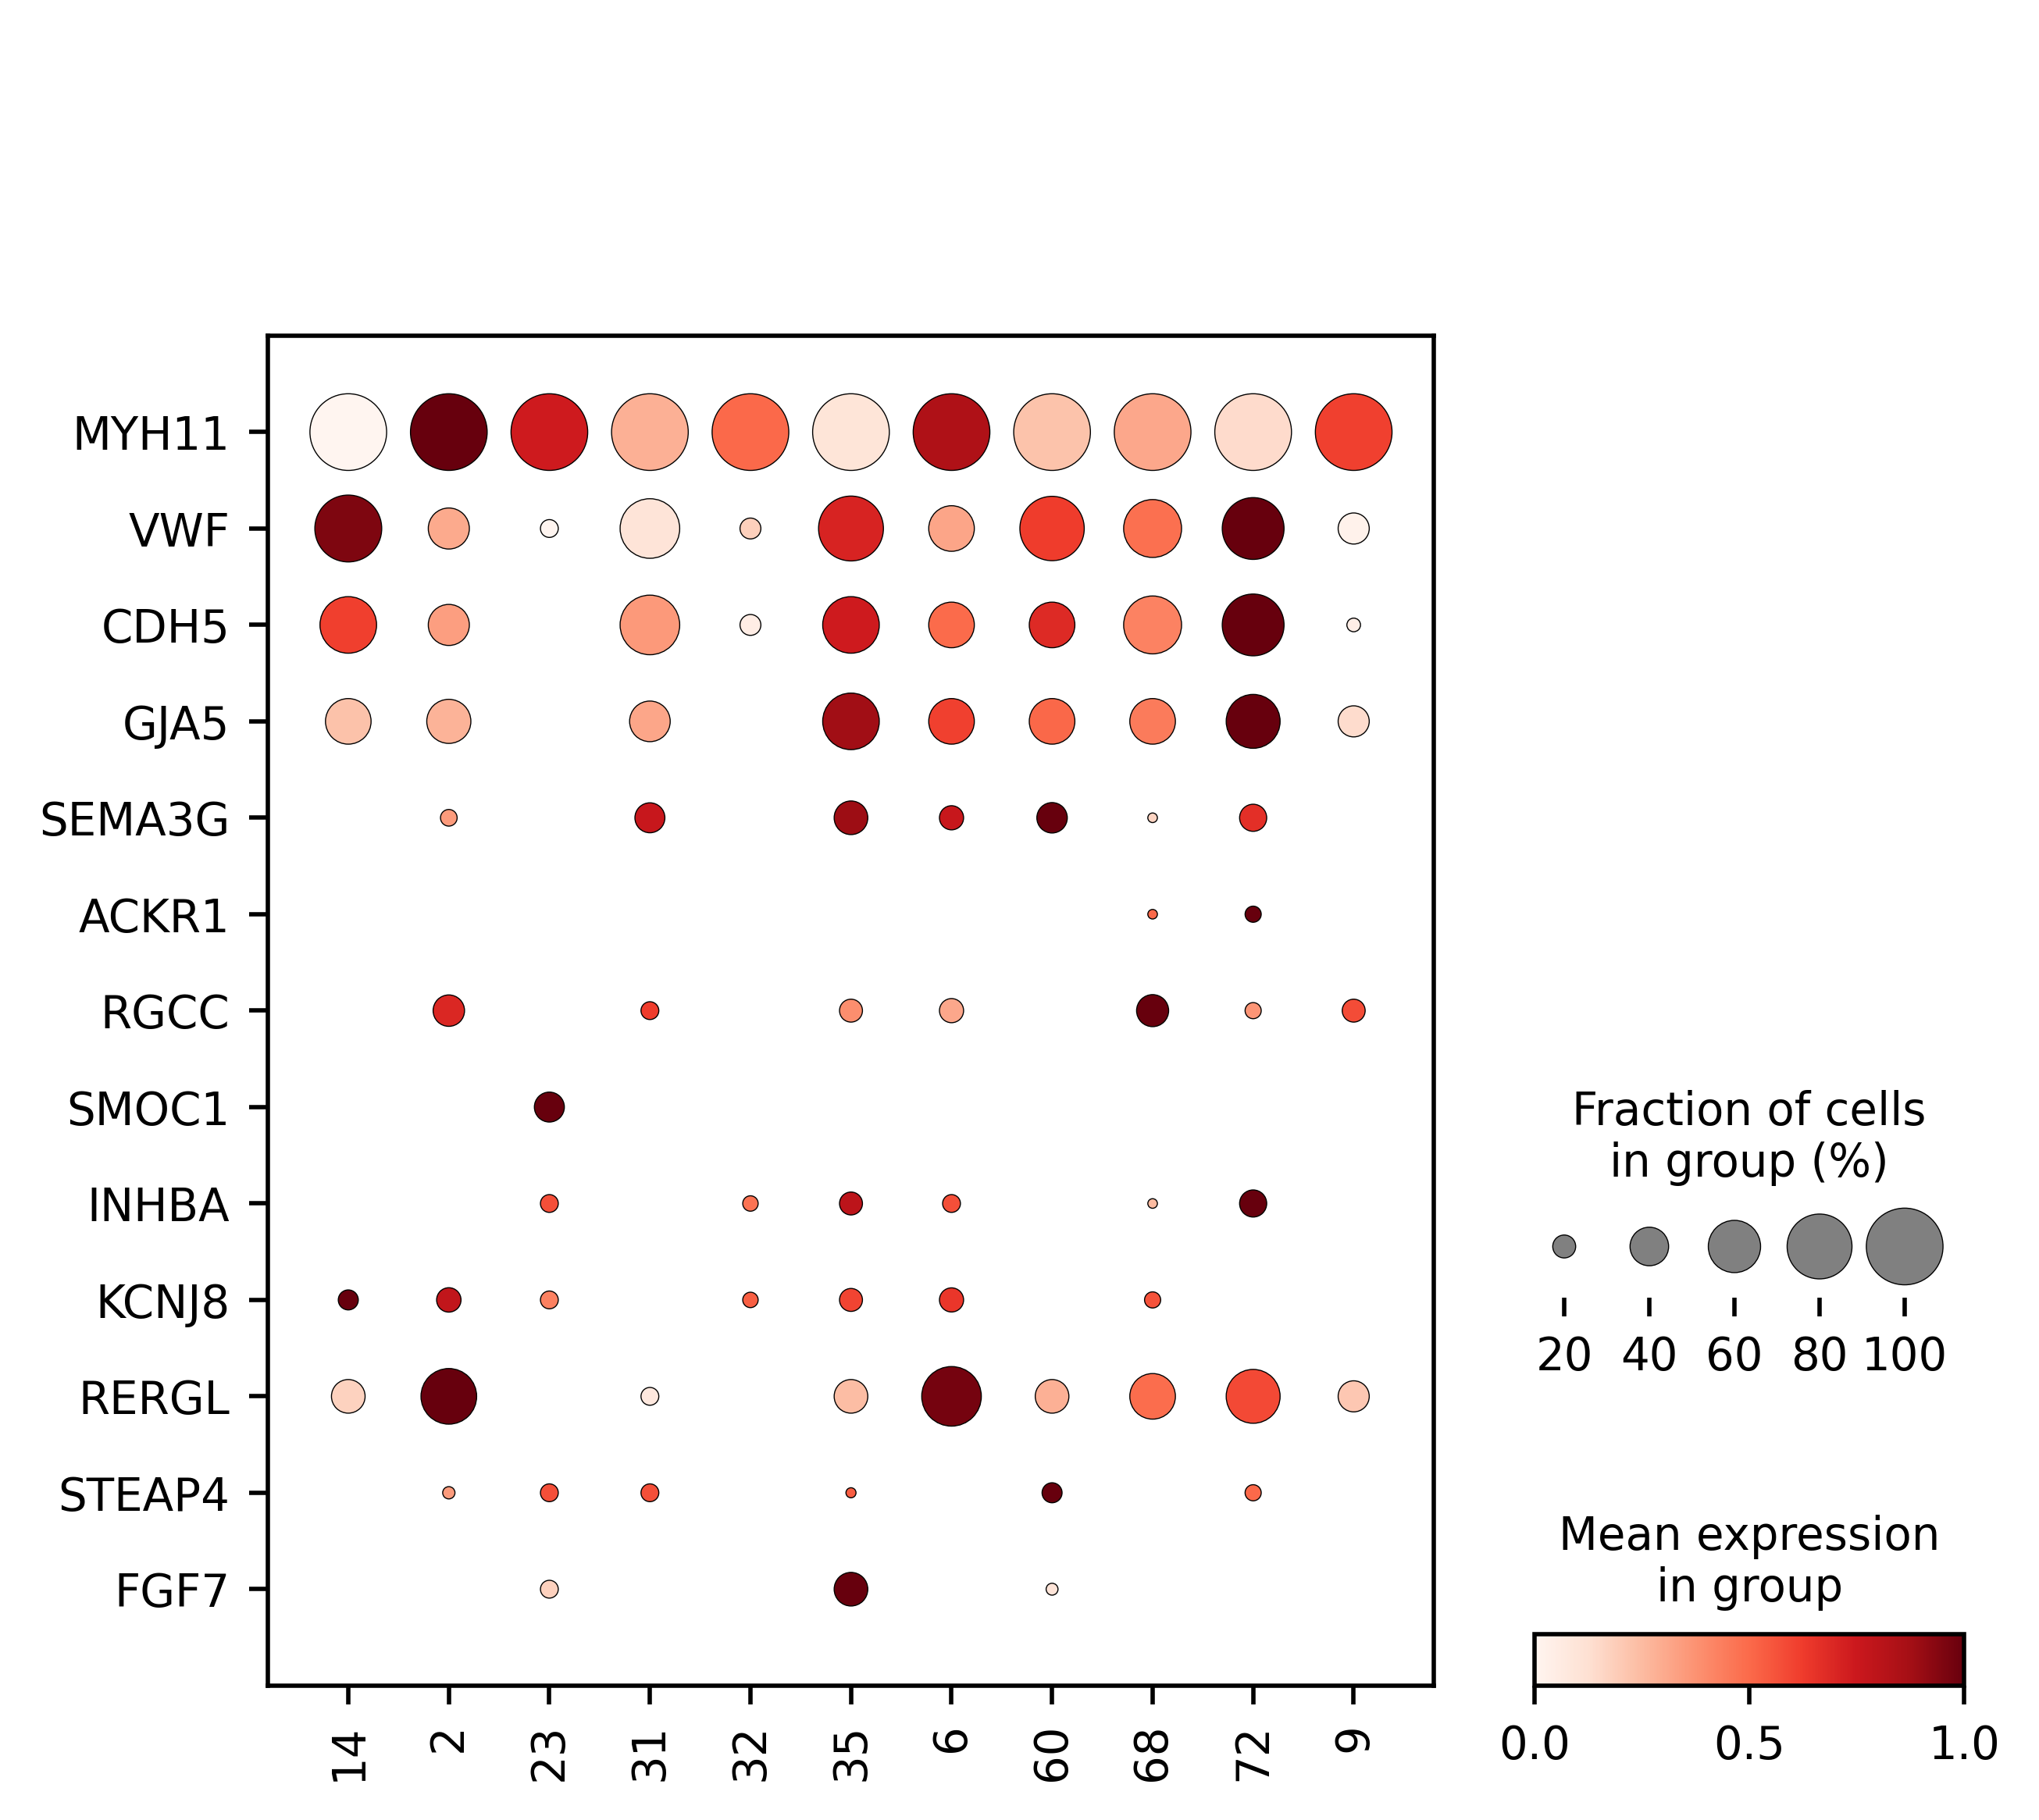

In [44]:
markers = ["MYH11","VWF","CDH5","GJA5","SEMA3G","ACKR1","RGCC","SMOC1","INHBA","KCNJ8","RERGL","STEAP4","FGF7"]
sc.pl.dotplot(adata_aec_subset, markers, "SMC_clusters", cmap = 'Reds', swap_axes = True, standard_scale = 'var')

In [45]:
#add vessel type annotation column

In [46]:
test["Vessel"] = ['Artery','Artery','Endocardium','Artery','Endocardium','Artery','Artery','Artery','Artery','Artery','Artery']

In [47]:
test

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
14                 0.333333        0.000000      0.000000       0.166667   
2                  0.652174        0.086957      0.000000       0.217391   
23                 0.000000        0.142857      0.142857       0.142857   
31                 0.142857        0.142857      0.000000       0.000000   
32                 0.000000        0.000000      0.000000       0.117647   
35                 0.333333        0.066667      0.333333       0.200000   
6                  0.714286        0.000000      0.000000       0.214286   
60                 0.333333        0.166667      0.083333       0.000000   
68                 0.500000        0.000000      0.000000       0.125000   
72                 0.625000        0.125000      0.000000       0.000000   
9                  0.300000        0.000000      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  \
SMC_clusters                                                           
14               0.666667             0.000000              0.000000   
2                0.782609             0.000000              0.000000   
23               0.571429             0.000000              0.000000   
31               0.571429             0.000000              0.000000   
32               0.058824             0.000000              0.000000   
35               0.666667             0.066667              0.066667   
6                0.785714             0.000000              0.000000   
60               0.666667             0.000000              0.000000   
68               0.750000             0.000000              0.000000   
72               0.500000             0.000000              0.000000   
9                0.100000             0.000000              0.000000   

                 RERGL  STEAP4  FGF7       AGT  KCNJ8    SEMA3G  ACKR1  \
SMC_clusters                                                             
14            1.000000     NaN   NaN  4.750000    2.0       NaN    NaN   
2             2.933333     1.0   NaN  2.888889    1.2  1.000000    NaN   
23                 NaN     1.0   1.0  2.500000    1.0       NaN    NaN   
31            1.000000     1.0   NaN  1.000000    NaN  1.000000    NaN   
32                 NaN     NaN   NaN  1.000000    1.5       NaN    NaN   
35            1.400000     2.0   2.4  4.600000    1.0  1.000000    NaN   
6             2.600000     NaN   NaN  2.818182    1.0  1.333333    NaN   
60            1.625000     1.5   1.0  2.812500    NaN  1.285714    NaN   
68            1.875000     NaN   NaN  6.250000    1.5  1.000000    1.0   
72            1.800000     1.0   NaN  1.500000    NaN  1.000000    1.0   
9             1.333333     NaN   NaN  1.000000    NaN       NaN    NaN   

                  RGCC  SMOC1       Vessel  
SMC_clusters                                
14                 NaN    NaN       Artery  
2             1.571429    NaN       Artery  
23                 NaN    1.0  Endocardium  
31            3.000000    NaN       Artery  
32                 NaN    NaN  Endocardium  
35            1.333333    NaN       Artery  
6             1.000000    NaN       Artery  
60                 NaN    NaN       Artery  
68            2.200000    NaN       Artery  
72            2.000000    NaN       Artery  
9             2.000000    NaN       Artery

### add vessel size numbers

In [48]:
adata_aec_subset.obs.SMC_clusters.value_counts()

60    24
2     23
32    17
68    16
35    15
6     14
9     10
72     8
23     7
31     7
14     6
Name: SMC_clusters, dtype: int64

In [49]:
test2 = test.join(adata_aec_subset.obs['SMC_clusters'].value_counts(), on=None, how='left', lsuffix='', rsuffix='', sort=False, validate=None)

In [50]:
test2.columns = list(test2.columns[0:17]) + ['size']

In [51]:
test2

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
14                 0.333333        0.000000      0.000000       0.166667   
2                  0.652174        0.086957      0.000000       0.217391   
23                 0.000000        0.142857      0.142857       0.142857   
31                 0.142857        0.142857      0.000000       0.000000   
32                 0.000000        0.000000      0.000000       0.117647   
35                 0.333333        0.066667      0.333333       0.200000   
6                  0.714286        0.000000      0.000000       0.214286   
60                 0.333333        0.166667      0.083333       0.000000   
68                 0.500000        0.000000      0.000000       0.125000   
72                 0.625000        0.125000      0.000000       0.000000   
9                  0.300000        0.000000      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  \
SMC_clusters                                                           
14               0.666667             0.000000              0.000000   
2                0.782609             0.000000              0.000000   
23               0.571429             0.000000              0.000000   
31               0.571429             0.000000              0.000000   
32               0.058824             0.000000              0.000000   
35               0.666667             0.066667              0.066667   
6                0.785714             0.000000              0.000000   
60               0.666667             0.000000              0.000000   
68               0.750000             0.000000              0.000000   
72               0.500000             0.000000              0.000000   
9                0.100000             0.000000              0.000000   

                 RERGL  STEAP4  FGF7       AGT  KCNJ8    SEMA3G  ACKR1  \
SMC_clusters                                                             
14            1.000000     NaN   NaN  4.750000    2.0       NaN    NaN   
2             2.933333     1.0   NaN  2.888889    1.2  1.000000    NaN   
23                 NaN     1.0   1.0  2.500000    1.0       NaN    NaN   
31            1.000000     1.0   NaN  1.000000    NaN  1.000000    NaN   
32                 NaN     NaN   NaN  1.000000    1.5       NaN    NaN   
35            1.400000     2.0   2.4  4.600000    1.0  1.000000    NaN   
6             2.600000     NaN   NaN  2.818182    1.0  1.333333    NaN   
60            1.625000     1.5   1.0  2.812500    NaN  1.285714    NaN   
68            1.875000     NaN   NaN  6.250000    1.5  1.000000    1.0   
72            1.800000     1.0   NaN  1.500000    NaN  1.000000    1.0   
9             1.333333     NaN   NaN  1.000000    NaN       NaN    NaN   

                  RGCC  SMOC1       Vessel  size  
SMC_clusters                                      
14                 NaN    NaN       Artery     6  
2             1.571429    NaN       Artery    23  
23                 NaN    1.0  Endocardium     7  
31            3.000000    NaN       Artery     7  
32                 NaN    NaN  Endocardium    17  
35            1.333333    NaN       Artery    15  
6             1.000000    NaN       Artery    14  
60                 NaN    NaN       Artery    24  
68            2.200000    NaN       Artery    16  
72            2.000000    NaN       Artery     8  
9             2.000000    NaN       Artery    10

In [52]:
group=pd.Series("Large", index=test2.index)

In [53]:
group[test2["size"] <= 30] = "Small"

In [54]:
group

SMC_clusters
14    Small
2     Small
23    Small
31    Small
32    Small
35    Small
6     Small
60    Small
68    Small
72    Small
9     Small
dtype: object

In [55]:
test2["group"] = group

In [56]:
test2

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
14                 0.333333        0.000000      0.000000       0.166667   
2                  0.652174        0.086957      0.000000       0.217391   
23                 0.000000        0.142857      0.142857       0.142857   
31                 0.142857        0.142857      0.000000       0.000000   
32                 0.000000        0.000000      0.000000       0.117647   
35                 0.333333        0.066667      0.333333       0.200000   
6                  0.714286        0.000000      0.000000       0.214286   
60                 0.333333        0.166667      0.083333       0.000000   
68                 0.500000        0.000000      0.000000       0.125000   
72                 0.625000        0.125000      0.000000       0.000000   
9                  0.300000        0.000000      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  \
SMC_clusters                                                           
14               0.666667             0.000000              0.000000   
2                0.782609             0.000000              0.000000   
23               0.571429             0.000000              0.000000   
31               0.571429             0.000000              0.000000   
32               0.058824             0.000000              0.000000   
35               0.666667             0.066667              0.066667   
6                0.785714             0.000000              0.000000   
60               0.666667             0.000000              0.000000   
68               0.750000             0.000000              0.000000   
72               0.500000             0.000000              0.000000   
9                0.100000             0.000000              0.000000   

                 RERGL  STEAP4  FGF7       AGT  KCNJ8    SEMA3G  ACKR1  \
SMC_clusters                                                             
14            1.000000     NaN   NaN  4.750000    2.0       NaN    NaN   
2             2.933333     1.0   NaN  2.888889    1.2  1.000000    NaN   
23                 NaN     1.0   1.0  2.500000    1.0       NaN    NaN   
31            1.000000     1.0   NaN  1.000000    NaN  1.000000    NaN   
32                 NaN     NaN   NaN  1.000000    1.5       NaN    NaN   
35            1.400000     2.0   2.4  4.600000    1.0  1.000000    NaN   
6             2.600000     NaN   NaN  2.818182    1.0  1.333333    NaN   
60            1.625000     1.5   1.0  2.812500    NaN  1.285714    NaN   
68            1.875000     NaN   NaN  6.250000    1.5  1.000000    1.0   
72            1.800000     1.0   NaN  1.500000    NaN  1.000000    1.0   
9             1.333333     NaN   NaN  1.000000    NaN       NaN    NaN   

                  RGCC  SMOC1       Vessel  size  group  
SMC_clusters                                             
14                 NaN    NaN       Artery     6  Small  
2             1.571429    NaN       Artery    23  Small  
23                 NaN    1.0  Endocardium     7  Small  
31            3.000000    NaN       Artery     7  Small  
32                 NaN    NaN  Endocardium    17  Small  
35            1.333333    NaN       Artery    15  Small  
6             1.000000    NaN       Artery    14  Small  
60                 NaN    NaN       Artery    24  Small  
68            2.200000    NaN       Artery    16  Small  
72            2.000000    NaN       Artery     8  Small  
9             2.000000    NaN       Artery    10  Small

In [57]:
test2["vessel_size"] = test2["Vessel"] + "_" + test2["group"]

In [58]:
test2

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
SMC_clusters                                                               
14                 0.333333        0.000000      0.000000       0.166667   
2                  0.652174        0.086957      0.000000       0.217391   
23                 0.000000        0.142857      0.142857       0.142857   
31                 0.142857        0.142857      0.000000       0.000000   
32                 0.000000        0.000000      0.000000       0.117647   
35                 0.333333        0.066667      0.333333       0.200000   
6                  0.714286        0.000000      0.000000       0.214286   
60                 0.333333        0.166667      0.083333       0.000000   
68                 0.500000        0.000000      0.000000       0.125000   
72                 0.625000        0.125000      0.000000       0.000000   
9                  0.300000        0.000000      0.000000       0.000000   

              AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent  \
SMC_clusters                                                           
14               0.666667             0.000000              0.000000   
2                0.782609             0.000000              0.000000   
23               0.571429             0.000000              0.000000   
31               0.571429             0.000000              0.000000   
32               0.058824             0.000000              0.000000   
35               0.666667             0.066667              0.066667   
6                0.785714             0.000000              0.000000   
60               0.666667             0.000000              0.000000   
68               0.750000             0.000000              0.000000   
72               0.500000             0.000000              0.000000   
9                0.100000             0.000000              0.000000   

                 RERGL  STEAP4  FGF7       AGT  KCNJ8    SEMA3G  ACKR1  \
SMC_clusters                                                             
14            1.000000     NaN   NaN  4.750000    2.0       NaN    NaN   
2             2.933333     1.0   NaN  2.888889    1.2  1.000000    NaN   
23                 NaN     1.0   1.0  2.500000    1.0       NaN    NaN   
31            1.000000     1.0   NaN  1.000000    NaN  1.000000    NaN   
32                 NaN     NaN   NaN  1.000000    1.5       NaN    NaN   
35            1.400000     2.0   2.4  4.600000    1.0  1.000000    NaN   
6             2.600000     NaN   NaN  2.818182    1.0  1.333333    NaN   
60            1.625000     1.5   1.0  2.812500    NaN  1.285714    NaN   
68            1.875000     NaN   NaN  6.250000    1.5  1.000000    1.0   
72            1.800000     1.0   NaN  1.500000    NaN  1.000000    1.0   
9             1.333333     NaN   NaN  1.000000    NaN       NaN    NaN   

                  RGCC  SMOC1       Vessel  size  group        vessel_size  
SMC_clusters                                                                
14                 NaN    NaN       Artery     6  Small       Artery_Small  
2             1.571429    NaN       Artery    23  Small       Artery_Small  
23                 NaN    1.0  Endocardium     7  Small  Endocardium_Small  
31            3.000000    NaN       Artery     7  Small       Artery_Small  
32                 NaN    NaN  Endocardium    17  Small  Endocardium_Small  
35            1.333333    NaN       Artery    15  Small       Artery_Small  
6             1.000000    NaN       Artery    14  Small       Artery_Small  
60                 NaN    NaN       Artery    24  Small       Artery_Small  
68            2.200000    NaN       Artery    16  Small       Artery_Small  
72            2.000000    NaN       Artery     8  Small       Artery_Small  
9             2.000000    NaN       Artery    10  Small       Artery_Small

In [59]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### add ROI numbers

In [60]:
test2.index = ['ROI_A2-2_' + str(i) for i in test2.index.tolist()]

In [61]:
test2["ROI"] = "A2-2"

In [62]:
test2

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
ROI_A2-2_14       0.333333        0.000000      0.000000       0.166667   
ROI_A2-2_2        0.652174        0.086957      0.000000       0.217391   
ROI_A2-2_23       0.000000        0.142857      0.142857       0.142857   
ROI_A2-2_31       0.142857        0.142857      0.000000       0.000000   
ROI_A2-2_32       0.000000        0.000000      0.000000       0.117647   
ROI_A2-2_35       0.333333        0.066667      0.333333       0.200000   
ROI_A2-2_6        0.714286        0.000000      0.000000       0.214286   
ROI_A2-2_60       0.333333        0.166667      0.083333       0.000000   
ROI_A2-2_68       0.500000        0.000000      0.000000       0.125000   
ROI_A2-2_72       0.625000        0.125000      0.000000       0.000000   
ROI_A2-2_9        0.300000        0.000000      0.000000       0.000000   

             AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent     RERGL  \
ROI_A2-2_14     0.666667             0.000000              0.000000  1.000000   
ROI_A2-2_2      0.782609             0.000000              0.000000  2.933333   
ROI_A2-2_23     0.571429             0.000000              0.000000       NaN   
ROI_A2-2_31     0.571429             0.000000              0.000000  1.000000   
ROI_A2-2_32     0.058824             0.000000              0.000000       NaN   
ROI_A2-2_35     0.666667             0.066667              0.066667  1.400000   
ROI_A2-2_6      0.785714             0.000000              0.000000  2.600000   
ROI_A2-2_60     0.666667             0.000000              0.000000  1.625000   
ROI_A2-2_68     0.750000             0.000000              0.000000  1.875000   
ROI_A2-2_72     0.500000             0.000000              0.000000  1.800000   
ROI_A2-2_9      0.100000             0.000000              0.000000  1.333333   

             STEAP4  FGF7       AGT  KCNJ8    SEMA3G  ACKR1      RGCC  SMOC1  \
ROI_A2-2_14     NaN   NaN  4.750000    2.0       NaN    NaN       NaN    NaN   
ROI_A2-2_2      1.0   NaN  2.888889    1.2  1.000000    NaN  1.571429    NaN   
ROI_A2-2_23     1.0   1.0  2.500000    1.0       NaN    NaN       NaN    1.0   
ROI_A2-2_31     1.0   NaN  1.000000    NaN  1.000000    NaN  3.000000    NaN   
ROI_A2-2_32     NaN   NaN  1.000000    1.5       NaN    NaN       NaN    NaN   
ROI_A2-2_35     2.0   2.4  4.600000    1.0  1.000000    NaN  1.333333    NaN   
ROI_A2-2_6      NaN   NaN  2.818182    1.0  1.333333    NaN  1.000000    NaN   
ROI_A2-2_60     1.5   1.0  2.812500    NaN  1.285714    NaN       NaN    NaN   
ROI_A2-2_68     NaN   NaN  6.250000    1.5  1.000000    1.0  2.200000    NaN   
ROI_A2-2_72     1.0   NaN  1.500000    NaN  1.000000    1.0  2.000000    NaN   
ROI_A2-2_9      NaN   NaN  1.000000    NaN       NaN    NaN  2.000000    NaN   

                  Vessel  size  group        vessel_size   ROI  
ROI_A2-2_14       Artery     6  Small       Artery_Small  A2-2  
ROI_A2-2_2        Artery    23  Small       Artery_Small  A2-2  
ROI_A2-2_23  Endocardium     7  Small  Endocardium_Small  A2-2  
ROI_A2-2_31       Artery     7  Small       Artery_Small  A2-2  
ROI_A2-2_32  Endocardium    17  Small  Endocardium_Small  A2-2  
ROI_A2-2_35       Artery    15  Small       Artery_Small  A2-2  
ROI_A2-2_6        Artery    14  Small       Artery_Small  A2-2  
ROI_A2-2_60       Artery    24  Small       Artery_Small  A2-2  
ROI_A2-2_68       Artery    16  Small       Artery_Small  A2-2  
ROI_A2-2_72       Artery     8  Small       Artery_Small  A2-2  
ROI_A2-2_9        Artery    10  Small       Artery_Small  A2-2

[Text(0.5, 1.0, 'RERGL percentage expression')]

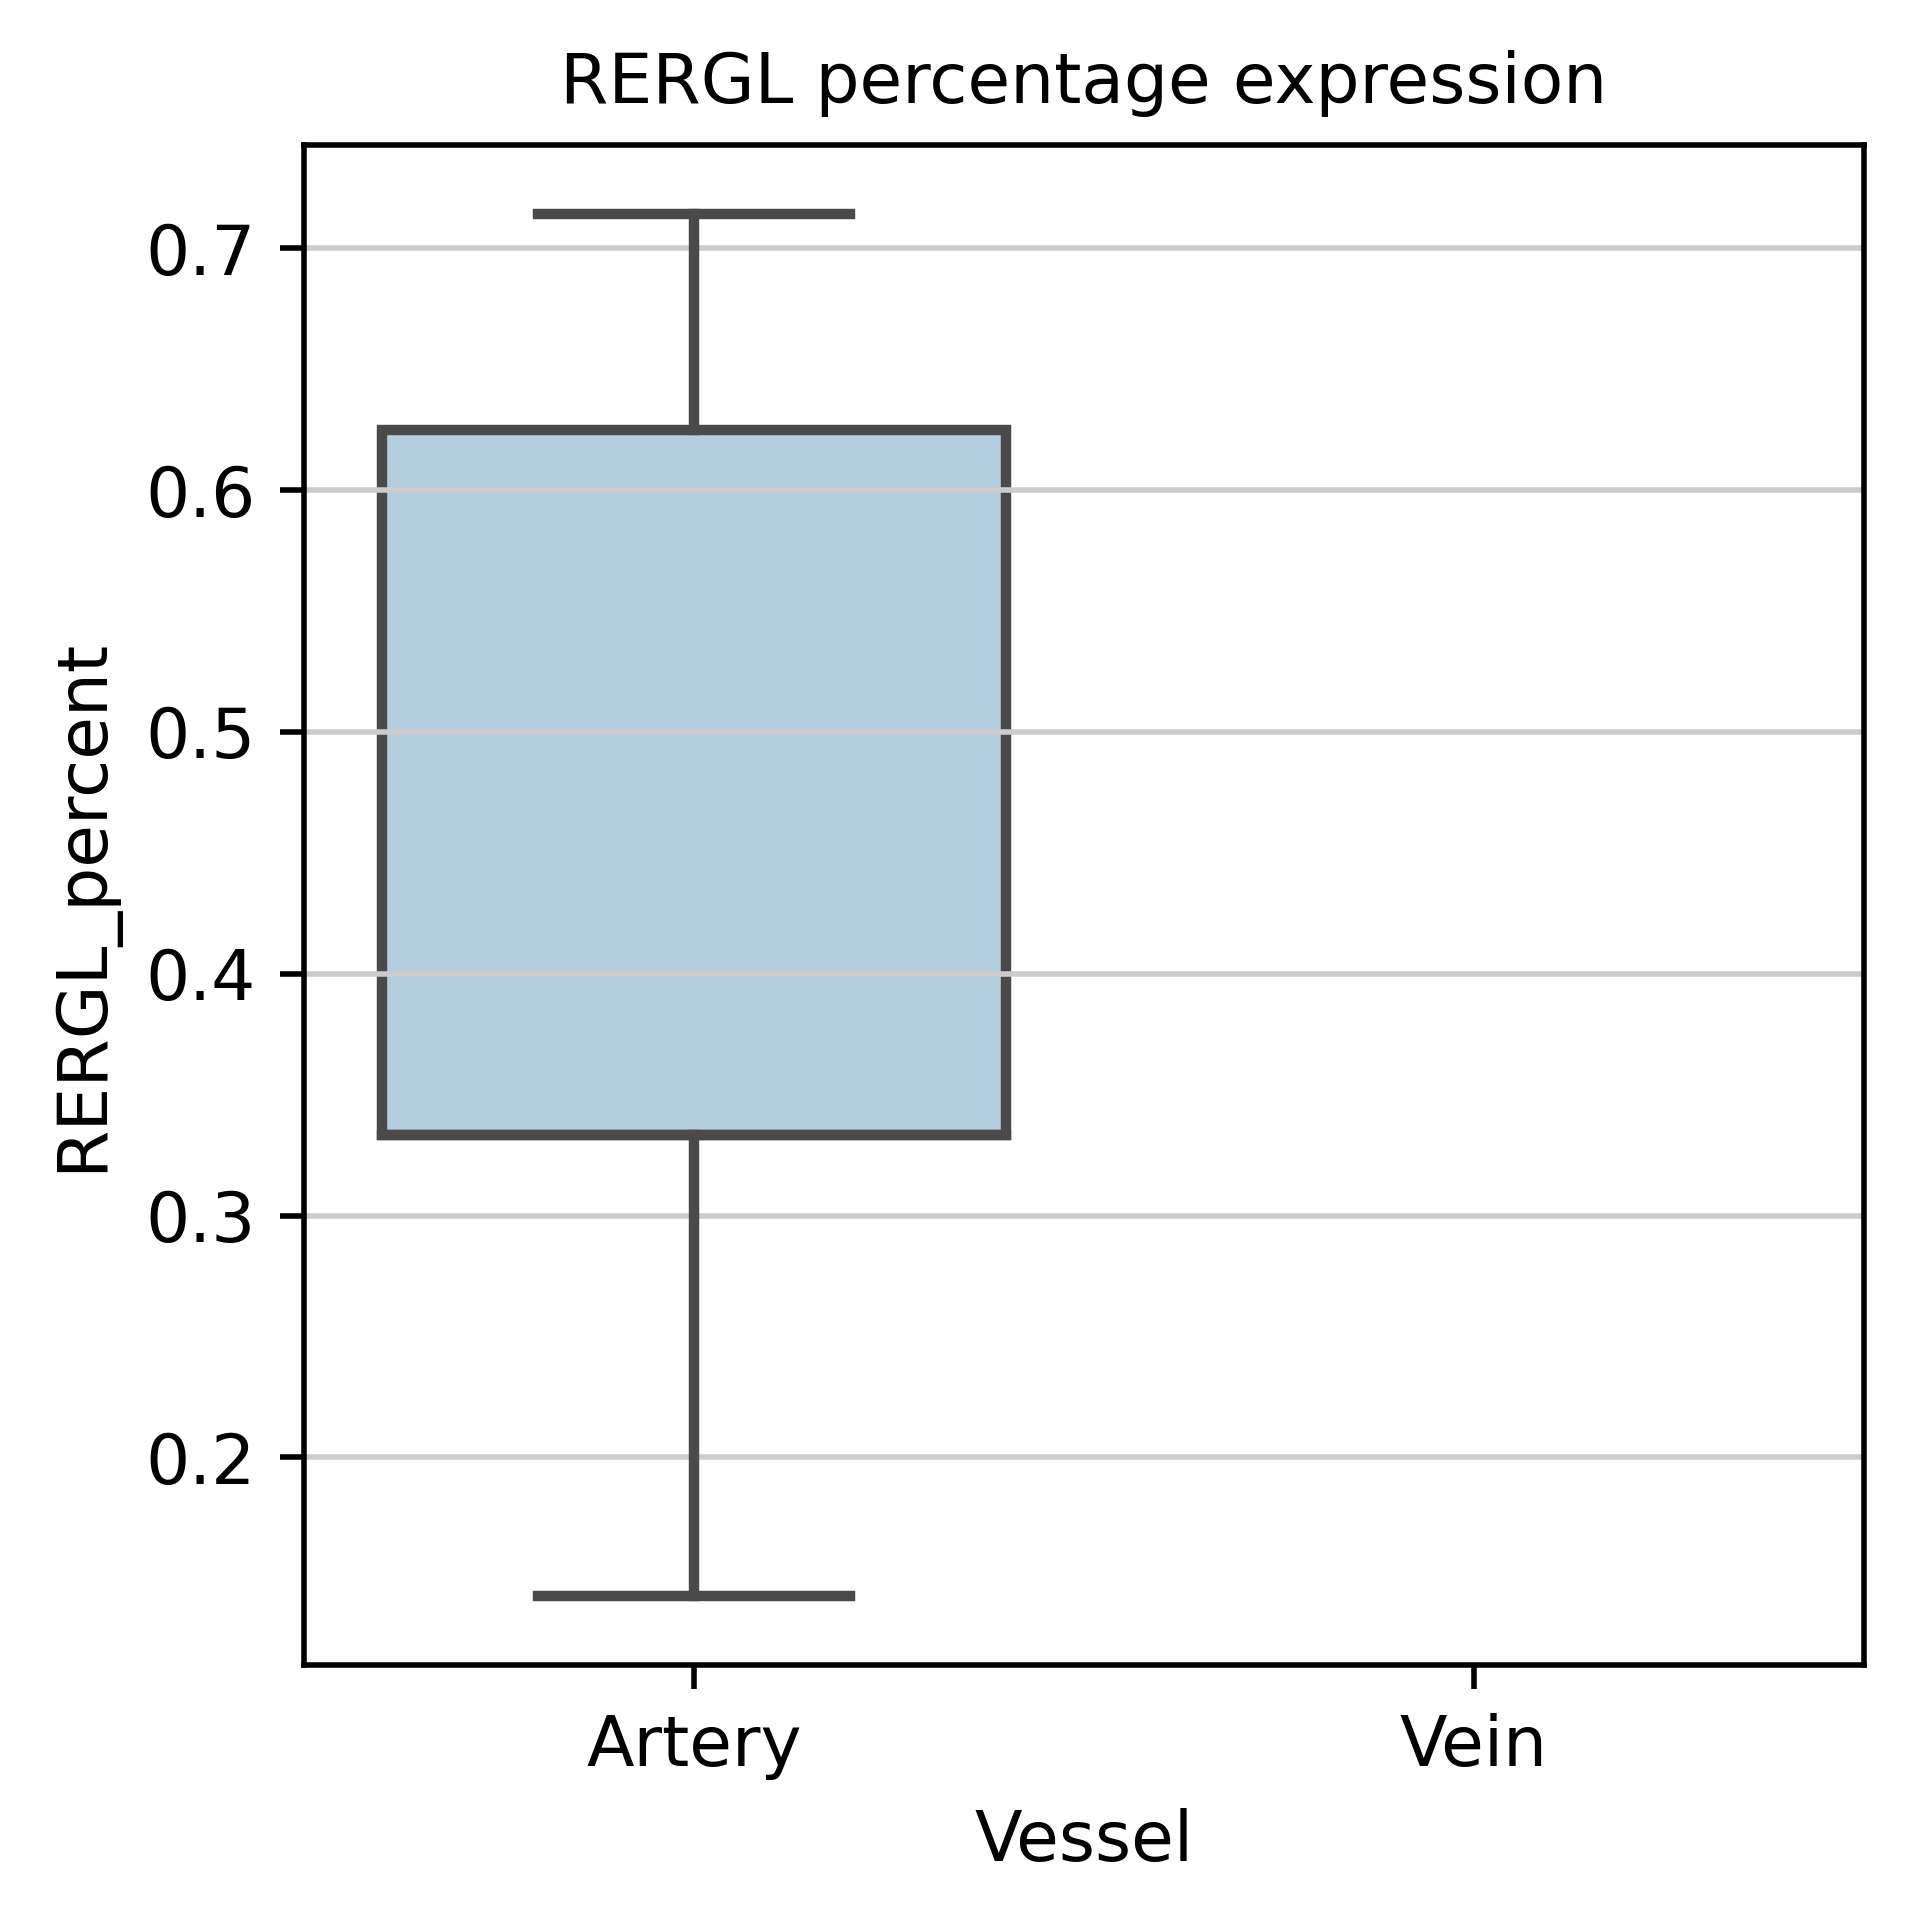

In [61]:
sns.boxplot(data = test, x = "Vessel", y = "RERGL_percent", palette = 'Blues', order = ['Artery','Vein']).set(title='RERGL percentage expression')

[Text(0.5, 1.0, 'RERGL mean expression')]

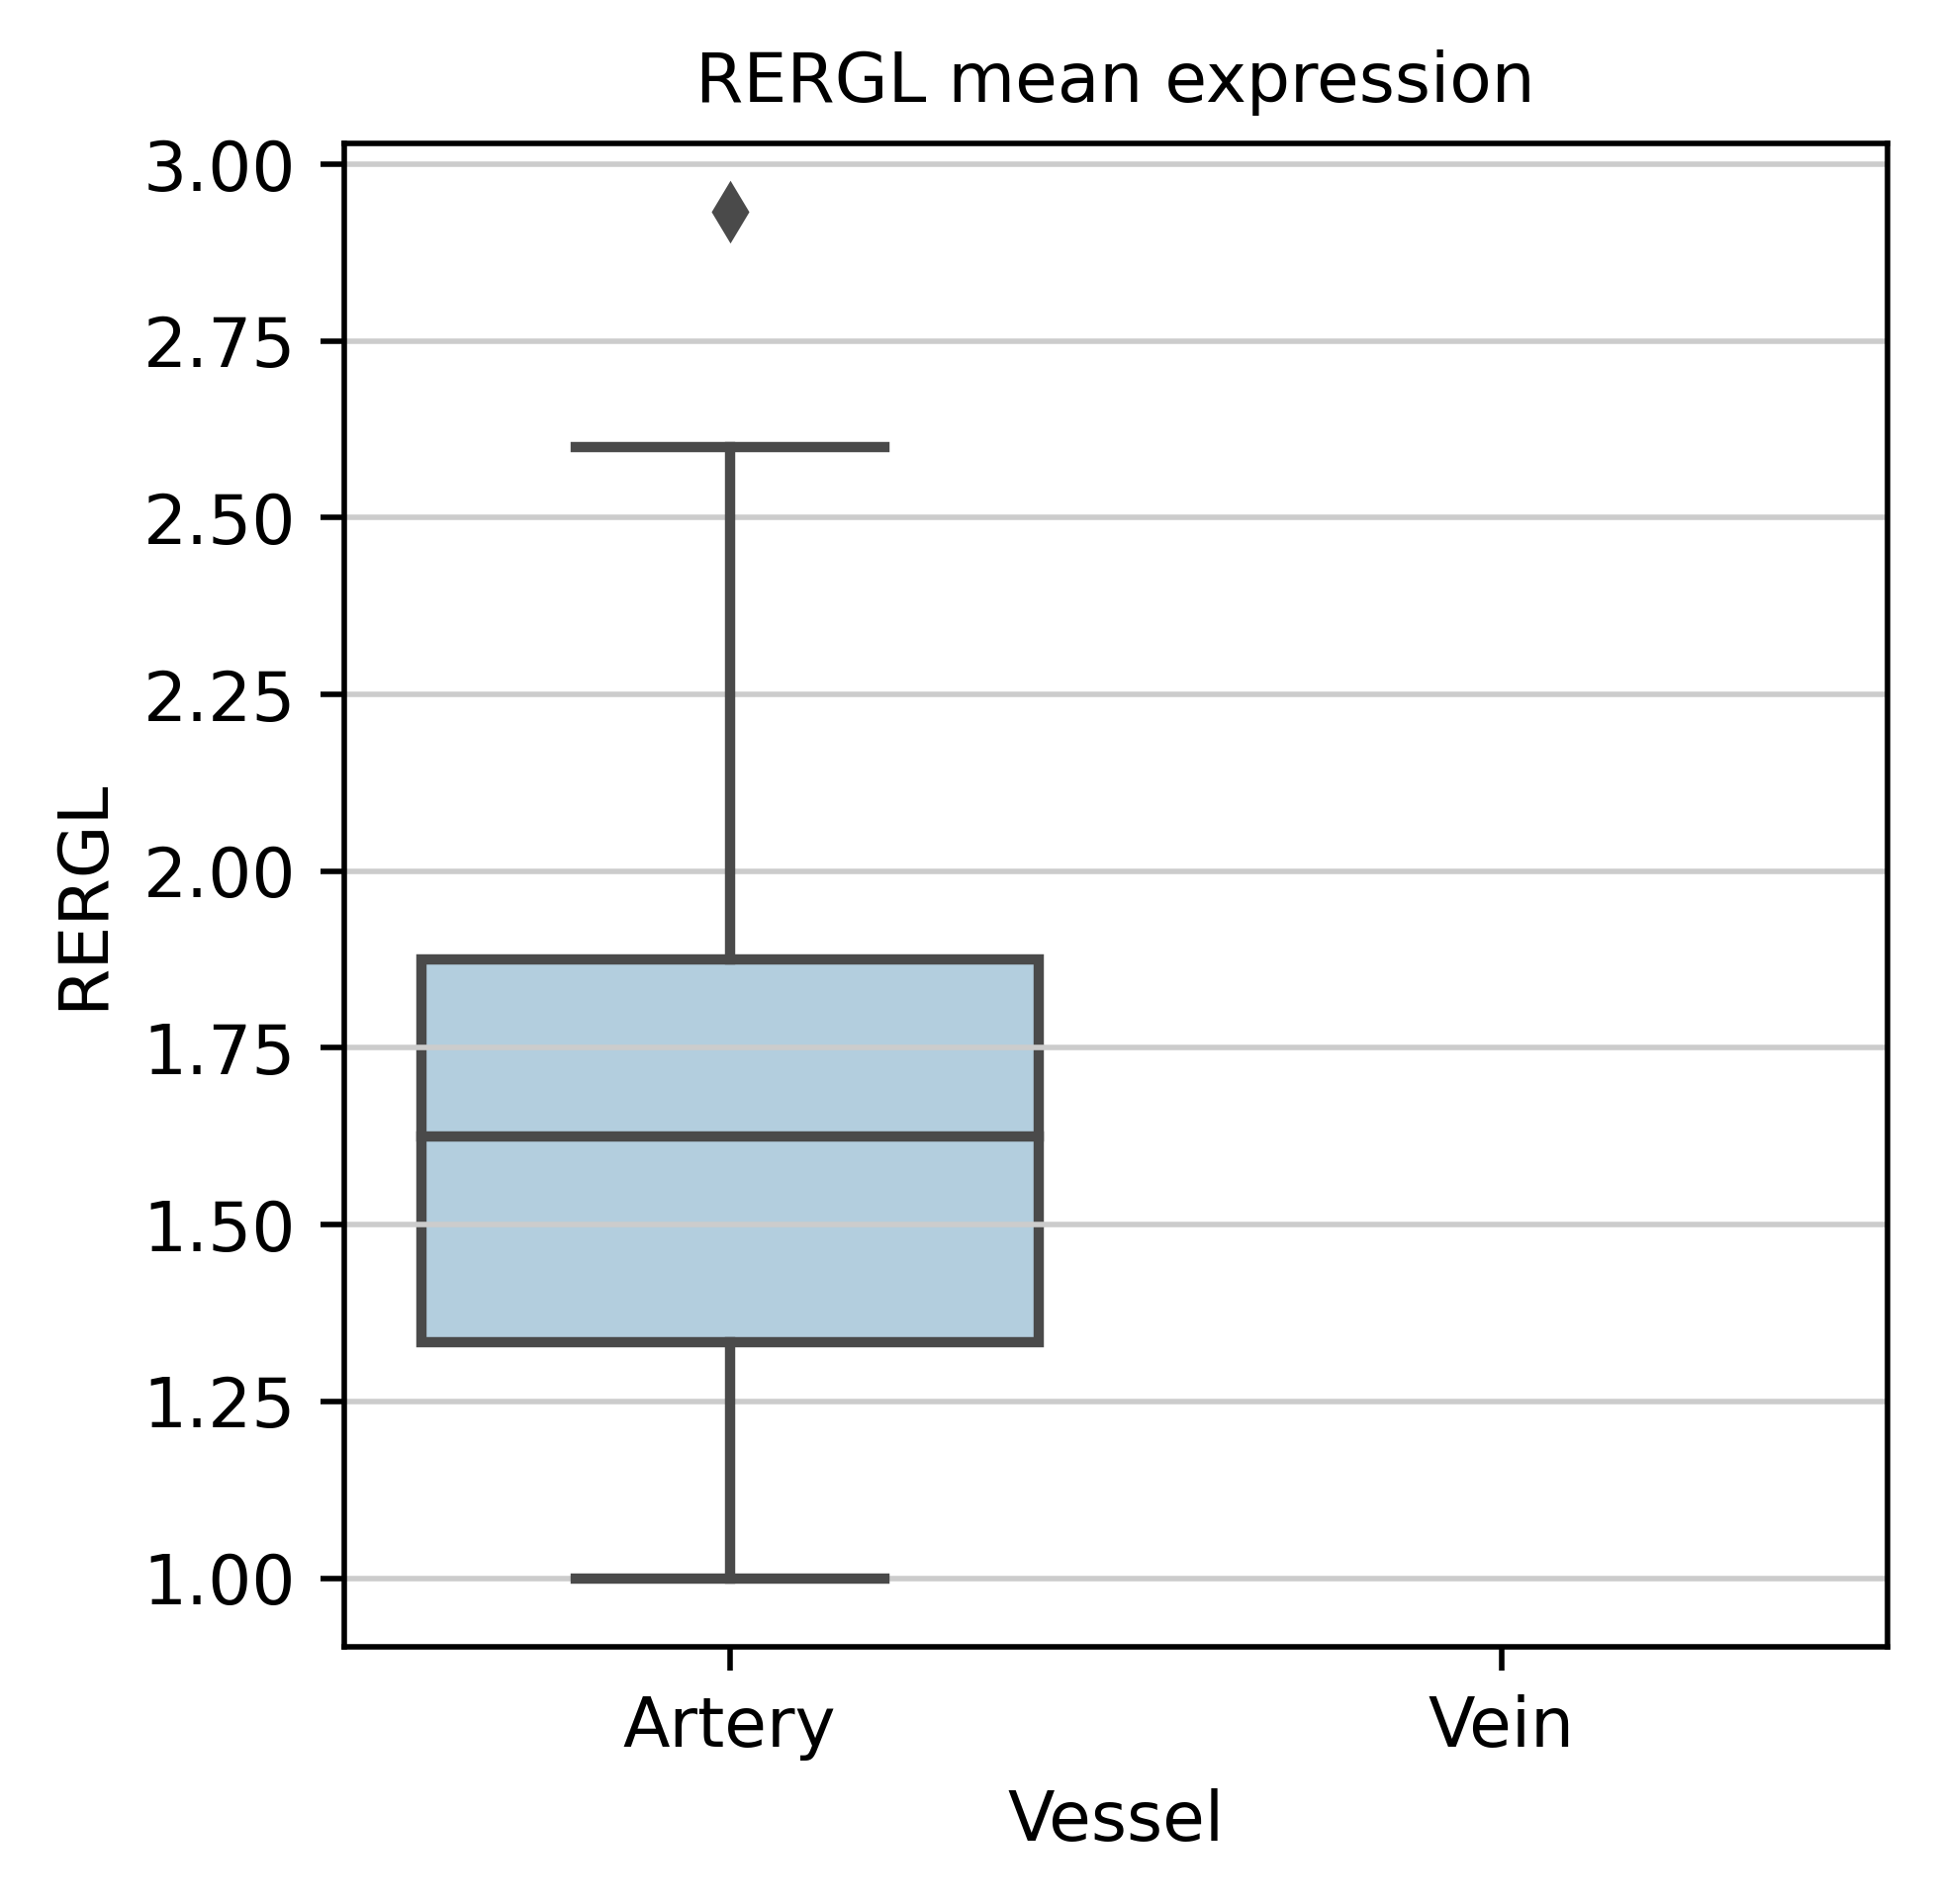

In [62]:
sns.boxplot(data = test, x = "Vessel", y = "RERGL", palette = 'Blues', order = ['Artery','Vein']).set(title='RERGL mean expression')

In [63]:
sns.boxplot(data = test, x = "Vessel", y = "STEAP4_percent", palette = 'Reds', order = ['Artery','Vein']).set(title='STEAP4 percentage expression')

[Text(0.5, 1.0, 'STEAP4 percentage expression')]

[Text(0.5, 1.0, 'STEAP4 mean expression')]

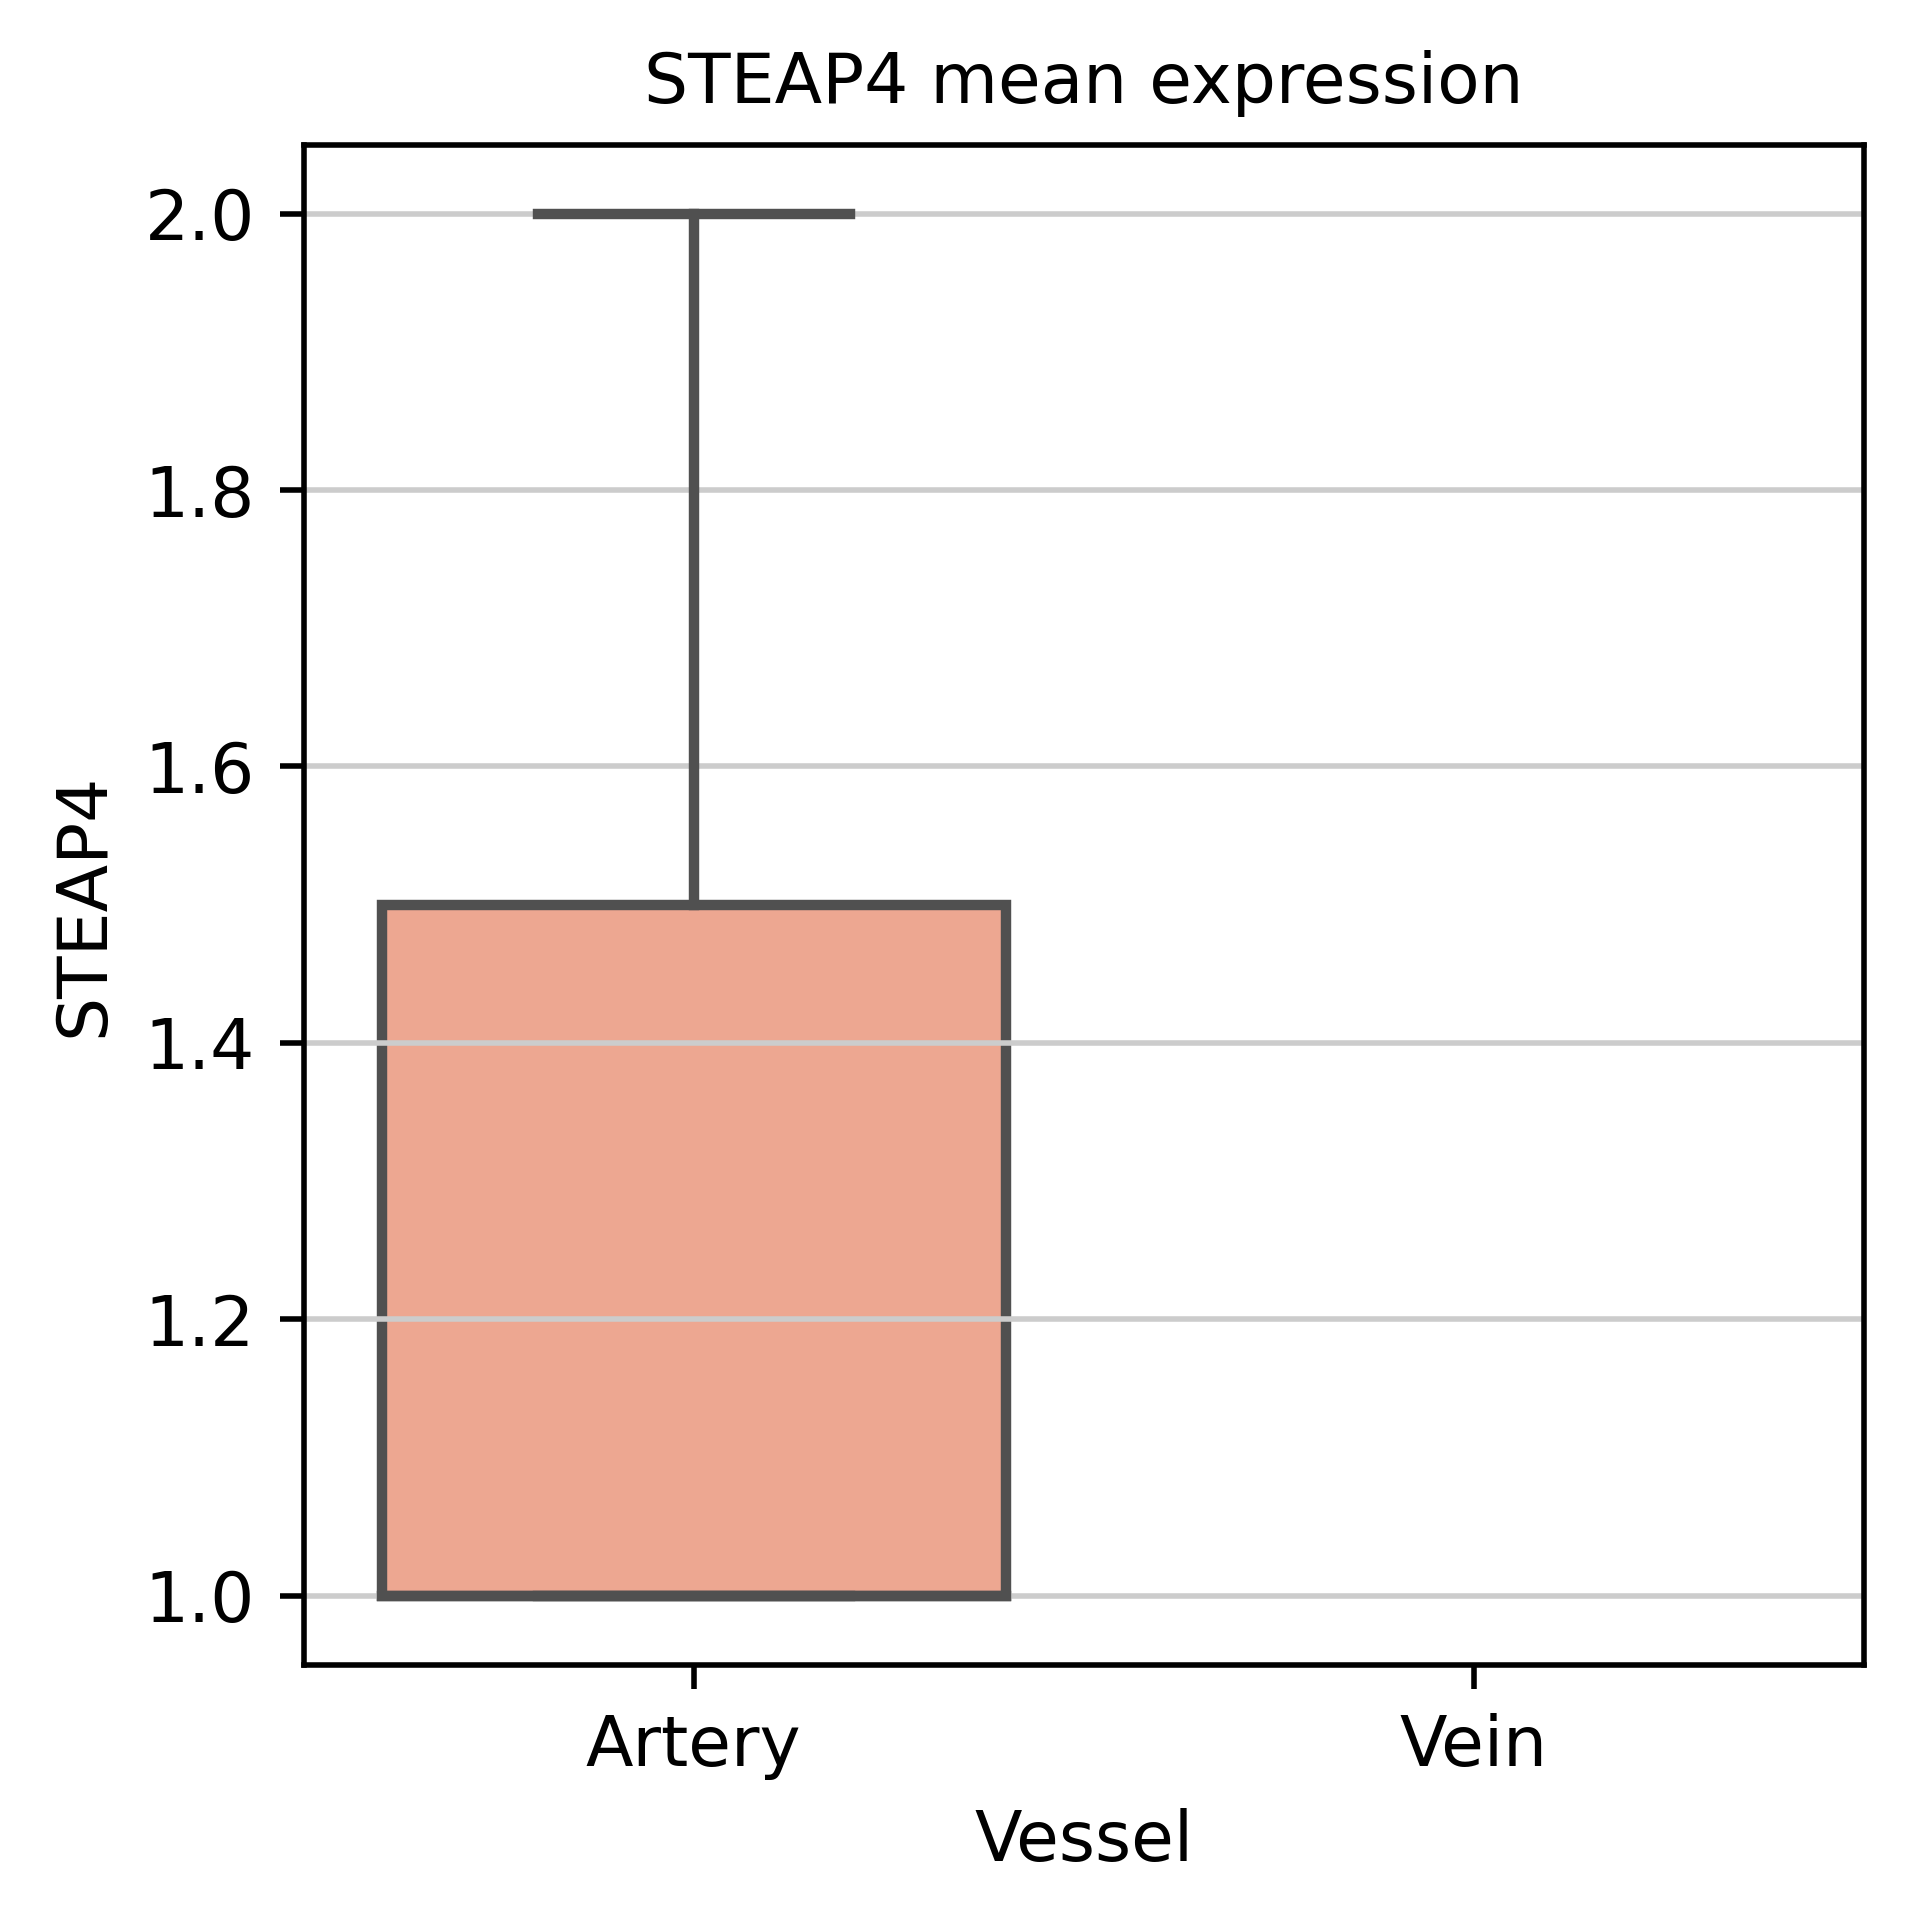

In [64]:
sns.boxplot(data = test, x = "Vessel", y = "STEAP4", palette = 'Reds', order = ['Artery','Vein']).set(title='STEAP4 mean expression')

In [65]:
test

RERGL_percent  STEAP4_percent  FGF7_percent  KCNJ8_percent  \
ROI_A2-2_14       0.333333        0.000000      0.000000       0.166667   
ROI_A2-2_2        0.652174        0.086957      0.000000       0.217391   
ROI_A2-2_23       0.000000        0.142857      0.142857       0.142857   
ROI_A2-2_31       0.142857        0.142857      0.000000       0.000000   
ROI_A2-2_32       0.000000        0.000000      0.000000       0.117647   
ROI_A2-2_35       0.333333        0.066667      0.333333       0.200000   
ROI_A2-2_6        0.714286        0.000000      0.000000       0.214286   
ROI_A2-2_60       0.333333        0.166667      0.083333       0.000000   
ROI_A2-2_68       0.500000        0.000000      0.000000       0.125000   
ROI_A2-2_72       0.625000        0.125000      0.000000       0.000000   
ROI_A2-2_9        0.300000        0.000000      0.000000       0.000000   

             AGT_percent  STEAP4_FGF7_percent  STEAP4_KCNJ8_percent     RERGL  \
ROI_A2-2_14     0.666667             0.000000              0.000000  1.000000   
ROI_A2-2_2      0.782609             0.000000              0.000000  2.933333   
ROI_A2-2_23     0.571429             0.000000              0.000000       NaN   
ROI_A2-2_31     0.571429             0.000000              0.000000  1.000000   
ROI_A2-2_32     0.058824             0.000000              0.000000       NaN   
ROI_A2-2_35     0.666667             0.066667              0.066667  1.400000   
ROI_A2-2_6      0.785714             0.000000              0.000000  2.600000   
ROI_A2-2_60     0.666667             0.000000              0.000000  1.625000   
ROI_A2-2_68     0.750000             0.000000              0.000000  1.875000   
ROI_A2-2_72     0.500000             0.000000              0.000000  1.800000   
ROI_A2-2_9      0.100000             0.000000              0.000000  1.333333   

             STEAP4  FGF7       AGT  KCNJ8    SEMA3G  ACKR1      RGCC  SMOC1  \
ROI_A2-2_14     NaN   NaN  4.750000    2.0       NaN    NaN       NaN    NaN   
ROI_A2-2_2      1.0   NaN  2.888889    1.2  1.000000    NaN  1.571429    NaN   
ROI_A2-2_23     1.0   1.0  2.500000    1.0       NaN    NaN       NaN    1.0   
ROI_A2-2_31     1.0   NaN  1.000000    NaN  1.000000    NaN  3.000000    NaN   
ROI_A2-2_32     NaN   NaN  1.000000    1.5       NaN    NaN       NaN    NaN   
ROI_A2-2_35     2.0   2.4  4.600000    1.0  1.000000    NaN  1.333333    NaN   
ROI_A2-2_6      NaN   NaN  2.818182    1.0  1.333333    NaN  1.000000    NaN   
ROI_A2-2_60     1.5   1.0  2.812500    NaN  1.285714    NaN       NaN    NaN   
ROI_A2-2_68     NaN   NaN  6.250000    1.5  1.000000    1.0  2.200000    NaN   
ROI_A2-2_72     1.0   NaN  1.500000    NaN  1.000000    1.0  2.000000    NaN   
ROI_A2-2_9      NaN   NaN  1.000000    NaN       NaN    NaN  2.000000    NaN   

                  Vessel   ROI  
ROI_A2-2_14       Artery  A2-2  
ROI_A2-2_2        Artery  A2-2  
ROI_A2-2_23  Endocardium  A2-2  
ROI_A2-2_31       Artery  A2-2  
ROI_A2-2_32  Endocardium  A2-2  
ROI_A2-2_35       Artery  A2-2  
ROI_A2-2_6        Artery  A2-2  
ROI_A2-2_60       Artery  A2-2  
ROI_A2-2_68       Artery  A2-2  
ROI_A2-2_72       Artery  A2-2  
ROI_A2-2_9        Artery  A2-2